In [13]:
# Importing Libraries

import os
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import metrics
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model, ensemble, tree
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score,GridSearchCV,cross_validate
from sklearn.metrics import confusion_matrix, auc,roc_auc_score,roc_curve,recall_score,classification_report
import xgboost as xgb
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 100, 'display.max_columns', 400)

# IMPORTING DATA

In [14]:
# Function to Load the file at specified path
# Parameters :- 1. path :- path from where file should be I

def Load_File(path) :
    if os.path.isfile(path) :
        data = pd.read_csv(path)
        data = data.replace('?', np.nan)
        print("\n" + "Number of rows in data are %s" % len(data))
        print("Number of columns in data are %s" % len(data.columns) + "\n")
        print("Following are the data types of columns:- ")
        print(data.dtypes)
        print("Number of missing values in the data are:- ")
        print(data.isnull().sum())
        print("Data Import is Complete")
        
        return data
    else:
        print(path + " does not exist. Enter the correct path")
        

# Generalized Function to plot the counts
# Parameters
# 1. rotx  : rotation of ticks on x-axis
# 2. roty  : rotation of ticks on y-axis
# 3. fontx : font size of ticks on x-axis
# 4. fonty : font size of ticks on y-axis
# 5. column_name : Name of the column for which we need the count
# 6. data_name   : Dataframe Used for plotting
# 7. plot_size   : Size of the plot
# 8. hue : If second column is needed for getting the count, the hue is True else False
# 9. hue_column_name = Second Column for plotting


def countplot(rotx, roty, fontx, fonty, column_name, data_name, plot_size = (10, 5), hue = False, hue_column_name=None):
    plt.figure(figsize = plot_size)
    plt.xticks(rotation=rotx, fontsize=fontx)
    plt.yticks(rotation=roty, fontsize=fonty)
    sns.set_style("whitegrid")
    if not hue:
        sns.countplot(column_name, data=data_name, palette='husl',
                      order = data_name[column_name].value_counts().index)
    else:
        sns.countplot(column_name, data=data_name, 
                      palette='husl', hue = hue_column_name,
                      order = data_name[column_name].value_counts().index)
    sns.despine()


# Function to Encode the Categorical Data Columns
# Parameters 1. df :- Dataframe 2. Column_name :- Feature to encode

def categorical_encoding(df, column_name_list=[]):
    
    for column_name in column_name_list:
        print(df[column_name].unique())
        categorical_columns = pd.get_dummies(df[column_name], prefix = column_name, 
                                             prefix_sep = '_', drop_first = False)
        df = pd.concat([df, categorical_columns], axis = 1)
        df = df.drop(column_name, axis = 1)
    return df


# Function to Label Encode the data
# Parameters :- 1. data :- Dataframe 2. columns_list :- List of columns to label encode

def labelEncoder(data, columns_list):
    for col in columns_list:
        encoder = LabelEncoder()
        data[col]  = encoder.fit_transform(data[col])
    return data


# Function to plot stacked plot
# Paramteres :- 
# data :- Dataframe used for plotting
# column_one :- Column One to group by
# column_two : Column Two to group by
# agg_column : Column to count numbers

def stacked_plot(data, column_one, column_two, agg_column, plot_size=(10, 5)):
    pal     = sns.color_palette("colorblind")
    grouped = data.groupby([column_one, column_two])[agg_column].count()
    grouped = grouped.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
    grouped = grouped.unstack(column_two).fillna(0)
    print(grouped)
    unique_list = list(data[column_two].unique())
    grouped[unique_list].plot(kind='bar', stacked=True, color=pal, figsize=plot_size)

Dari sini saya akan menambahkan komentar mengenai fitur-fitur yang ada pada satu tabel, penjelasan mengenai fiturnya bisa didapatkan melalui website resmi OULAD

In [15]:
# code_module          identification code of the module, to which the assessment belongs
# code_presentation    identification code of the presentation, to which the assessment belongs
# id_assessment        identification number of the assessment
# assessment_type      type of assessment
# date                 days information about the final submission date of the assessment calculated as the number of days 
#                      since the start of the module-presentation. The starting date of the presentation has number 0 (zero)
# weight               weight of the assessment in %. Typically, Exams are treated separately and have the weight 100%
#                      the sum of all other assessments is 100%

oulad_assessment = Load_File('assessments.csv')


Number of rows in data are 206
Number of columns in data are 6

Following are the data types of columns:- 
code_module           object
code_presentation     object
id_assessment          int64
assessment_type       object
date                 float64
weight               float64
dtype: object
Number of missing values in the data are:- 
code_module           0
code_presentation     0
id_assessment         0
assessment_type       0
date                 11
weight                0
dtype: int64
Data Import is Complete


In [16]:
oulad_assessment.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0


In [17]:
### Disini kita akan mengisi data kosong dengan mean tanggal yang ada pada tabel assesment pada kolom tanggal.

oulad_assessment['date'] = oulad_assessment['date'].fillna(int(oulad_assessment['date'].astype(float).mean()))

In [18]:
### Disini kita akan mencari ada berapa tipe modul

oulad_assessment['code_module'].unique()

array(['AAA', 'BBB', 'CCC', 'DDD', 'EEE', 'FFF', 'GGG'], dtype=object)

In [19]:
### Dan masing masing modul mempunyai 3 cara penilaian
# TMA :- Tutor Marked Assessment (Diberikan dosen)
# CMA :- Computer Marked Assessment (Diberikan sistem)
# Exam :- Final Exam

oulad_assessment['assessment_type'].unique()

array(['TMA', 'Exam', 'CMA'], dtype=object)

Histogram di bawah ini menunjukkan rentang (range) jumlah hari yang tersisa hingga batas waktu akhir pengumpulan suatu tugas atau proyek. Dalam konteks ini, histogram digunakan untuk memvisualisasikan sebaran atau distribusi berapa banyak hari yang tersisa hingga batas waktu akhir (misalnya, deadline) untuk pengumpulan suatu tugas atau proyek.

Histogram digunakan untuk melihat pola atau frekuensi berapa banyak tugas atau proyek yang memiliki berbagai jumlah hari tersisa hingga batas waktu akhir. Ini bisa membantu dalam memahami seberapa banyak tugas yang mungkin memiliki batas waktu yang mendekati atau melewati, atau seberapa banyak yang diselesaikan jauh sebelum batas waktu.

Dengan kata lain, histogram tersebut memberikan gambaran visual tentang bagaimana tugas-tugas atau proyek-proyek terdistribusi dalam hal jarak waktu yang tersisa hingga batas waktu akhirnya.

(array([29., 25., 22., 34., 20., 32., 44.]),
 array([ 12.        ,  47.57142857,  83.14285714, 118.71428571,
        154.28571429, 189.85714286, 225.42857143, 261.        ]),
 <BarContainer object of 7 artists>)

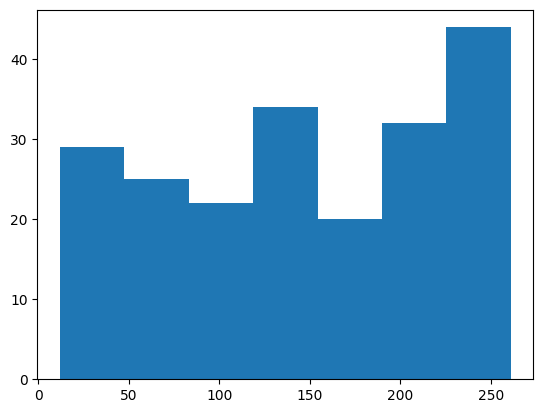

In [20]:
plt.hist(oulad_assessment['date'].astype(int), bins=7)

In [21]:
# code_module         name of the module, which serves as the identifier
# code_presentation   name of the presentation. It consists of the year and B for the presentation 
#                     starting in February and J for the presentation starting in October
# length              length of the module presentation in days

oulad_courses = Load_File('courses.csv')


Number of rows in data are 22
Number of columns in data are 3

Following are the data types of columns:- 
code_module                   object
code_presentation             object
module_presentation_length     int64
dtype: object
Number of missing values in the data are:- 
code_module                   0
code_presentation             0
module_presentation_length    0
dtype: int64
Data Import is Complete


In [22]:
oulad_courses.head()

,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269
2,BBB,2013J,268
3,BBB,2014J,262
4,BBB,2013B,240


In [23]:
# id_assessment            the identification number of the assessment
# id_student               a unique identification number for the student
# date_submitted           the date of student submission, measured as the number of days 
#.                         since the start of the module presentation
# is_banked                a status flag indicating that the assessment result has been transferred from a previous presentation
# score                    the studentís score in this assessment. The range is from 0 to 100. The score lower than 40 is 
#                          interpreted as Fail. The marks are in the range from 0 to 100

oulad_student_assessment = Load_File('studentAssessment.csv')


Number of rows in data are 173912
Number of columns in data are 5

Following are the data types of columns:- 
id_assessment       int64
id_student          int64
date_submitted      int64
is_banked           int64
score             float64
dtype: object
Number of missing values in the data are:- 
id_assessment       0
id_student          0
date_submitted      0
is_banked           0
score             173
dtype: int64
Data Import is Complete


In [24]:
### Disini akan kita drop nilai yang kosong, mengapa? Karena data yang hilang sangat sedikit (insignifikan) 
### dibandingkan total datanya

oulad_student_assessment = oulad_student_assessment.dropna()

In [25]:
oulad_student_assessment.head()

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0


In [26]:
# code_module             an identification code for a module
# code_presentation       the identification code of the presentation
# id_student              a unique identification number for the student
# date_registration       the date of student's registration on the module presentation, this is the number of days measured relative to 
#                         the start of the module-presentation (e.g. the negative value -30 means that the student registered to module
#                         presentation 30 days before it started)
# date_unregistration     date of student unregistration from the module presentation, this is the number of days measured relative to 
#                         the start of the module-presentation. Students, who completed the course have this field empty. Students who 
#                         unregistered have Withdrawal as the value of the final_result column in the studentInfo.csv file

oulad_student_registration = Load_File('studentRegistration.csv')


Number of rows in data are 32593
Number of columns in data are 5

Following are the data types of columns:- 
code_module             object
code_presentation       object
id_student               int64
date_registration      float64
date_unregistration    float64
dtype: object
Number of missing values in the data are:- 
code_module                0
code_presentation          0
id_student                 0
date_registration         45
date_unregistration    22521
dtype: int64
Data Import is Complete


In [27]:
## Dari deskripsi di atas maka bisa dilihat banyak sekali missing value pada kolom date_unreg
## jika tidak ada missing value maka dikatakan siswa telah menyelesaikan course sedangkan jika kosong dikatakan 'withdrawn'

## 0 : 'COMPLETED'
## 1 : 'WITHDRAWN'

## Karena sedikit sekali missing value pada kolom date_reg maka akan diisi dengan 0 begitu pula yang ada di kolom date_unreg
## sedangkan kolom date unregistration akan ditandai dengan 1 jika data tidak null

oulad_student_registration['date_unregistration'] = ['0' if pd.isnull(days) else '1' for days in oulad_student_registration['date_unregistration']]
oulad_student_registration['date_registration']   = oulad_student_registration['date_registration'].fillna(0).astype(float).apply(abs)


In [28]:
oulad_student_registration.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,159.0,0
1,AAA,2013J,28400,53.0,0
2,AAA,2013J,30268,92.0,1
3,AAA,2013J,31604,52.0,0
4,AAA,2013J,32885,176.0,0


In [29]:
"""Loading Student Information Data"""

# code_module             an identification code for a module on which the student is registered
# code_presentation       the identification code of the presentation during which the student is registered on the module
# id_student              a unique identification number for the student
# gender                  the studentís gender
# region                  identifies the geographic region, where the student lived while taking the module-presentation
# highest_education       highest student education level on entry to the module presentation
# imd_band                specifies the Index of Multiple Depravation band of the place where the student lived during the module-presentation
# age_band                band of the studentís age
# num_of_prev_attempts    the number times the student has attempted this module
# studied_credits         the total number of credits for the modules the student is currently studying
# disability              indicates whether the student has declared a disability
# final_result            studentís final result in the module-presentation

oulad_student_info = Load_File('studentInfo.csv')


Number of rows in data are 32593
Number of columns in data are 12

Following are the data types of columns:- 
code_module             object
code_presentation       object
id_student               int64
gender                  object
region                  object
highest_education       object
imd_band                object
age_band                object
num_of_prev_attempts     int64
studied_credits          int64
disability              object
final_result            object
dtype: object
Number of missing values in the data are:- 
code_module                0
code_presentation          0
id_student                 0
gender                     0
region                     0
highest_education          0
imd_band                1111
age_band                   0
num_of_prev_attempts       0
studied_credits            0
disability                 0
final_result               0
dtype: int64
Data Import is Complete


Ada nilai yang hilang (missing values) dalam kolom "imd_band." Kolom ini berisi informasi tentang kategori atau kelompok tertentu yang berkaitan dengan suatu data. Misalnya, "imd_band" bisa mengacu pada kelompok tingkat kekayaan atau indeks deprivasi.

Untuk mengatasi nilai yang hilang dalam kolom "imd_band," maka saya mengisi nilai-nilai yang hilang dengan nilai yang paling sering muncul dalam kolom tersebut. Nilai yang paling sering muncul ini disebut "mode." Pendekatan ini akan mengisi nilai-nilai yang hilang dengan kategori yang paling umum atau paling sering muncul dalam data, sehingga memungkinkan data tersebut untuk tetap digunakan dalam analisis atau pemodelan lebih lanjut tanpa menghilangkan baris dengan nilai yang hilang.

In [30]:
print(oulad_student_info['imd_band'].unique())

oulad_student_info['imd_band'] = oulad_student_info['imd_band'].fillna(oulad_student_info['imd_band'].mode()[0])

['90-100%' '20-30%' '30-40%' '50-60%' '80-90%' '70-80%' nan '60-70%'
 '40-50%' '10-20' '0-10%']


In [31]:
oulad_student_info.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass


In [32]:
# code_module           an identification code for a module
# code_presentation     the identification code of the module presentation
# id_student            a unique identification number for the student
# id_site               an identification number for the VLE material
# date                  the date of studentís interaction with the material measured as the 
#                       number of days since the start of the module-presentation
# sum_click             the number of times a student interacts with the material in that day 

oulad_student_vle = Load_File('studentVle.csv')


Number of rows in data are 10655280
Number of columns in data are 6

Following are the data types of columns:- 
code_module          object
code_presentation    object
id_student            int64
id_site               int64
date                  int64
sum_click             int64
dtype: object
Number of missing values in the data are:- 
code_module          0
code_presentation    0
id_student           0
id_site              0
date                 0
sum_click            0
dtype: int64
Data Import is Complete


In [33]:
oulad_student_vle.head()

,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1
2,AAA,2013J,28400,546652,-10,1
3,AAA,2013J,28400,546614,-10,11
4,AAA,2013J,28400,546714,-10,1


In [34]:
# id_site              an identification number of the material
# code_module          an identification code for module
# code_presentation    the identification code of presentation
# activity_type        the role associated with the module material
# week_from            the week from which the material is planned to be used
# week_to              week until which the material is planned to be used

oulad_vle = Load_File('vle.csv')


Number of rows in data are 6364
Number of columns in data are 6

Following are the data types of columns:- 
id_site                int64
code_module           object
code_presentation     object
activity_type         object
week_from            float64
week_to              float64
dtype: object
Number of missing values in the data are:- 
id_site                 0
code_module             0
code_presentation       0
activity_type           0
week_from            5243
week_to              5243
dtype: int64
Data Import is Complete


In [35]:
### Karena ada hampir 100% data yang hilang pada kolom week_from dan week_to maka kita drop saja kolomnya

oulad_vle = oulad_vle.drop(['week_from', 'week_to'], axis = 1)

In [36]:
oulad_vle.head()

,id_site,code_module,code_presentation,activity_type
0,546943,AAA,2013J,resource
1,546712,AAA,2013J,oucontent
2,546998,AAA,2013J,resource
3,546888,AAA,2013J,url
4,547035,AAA,2013J,resource


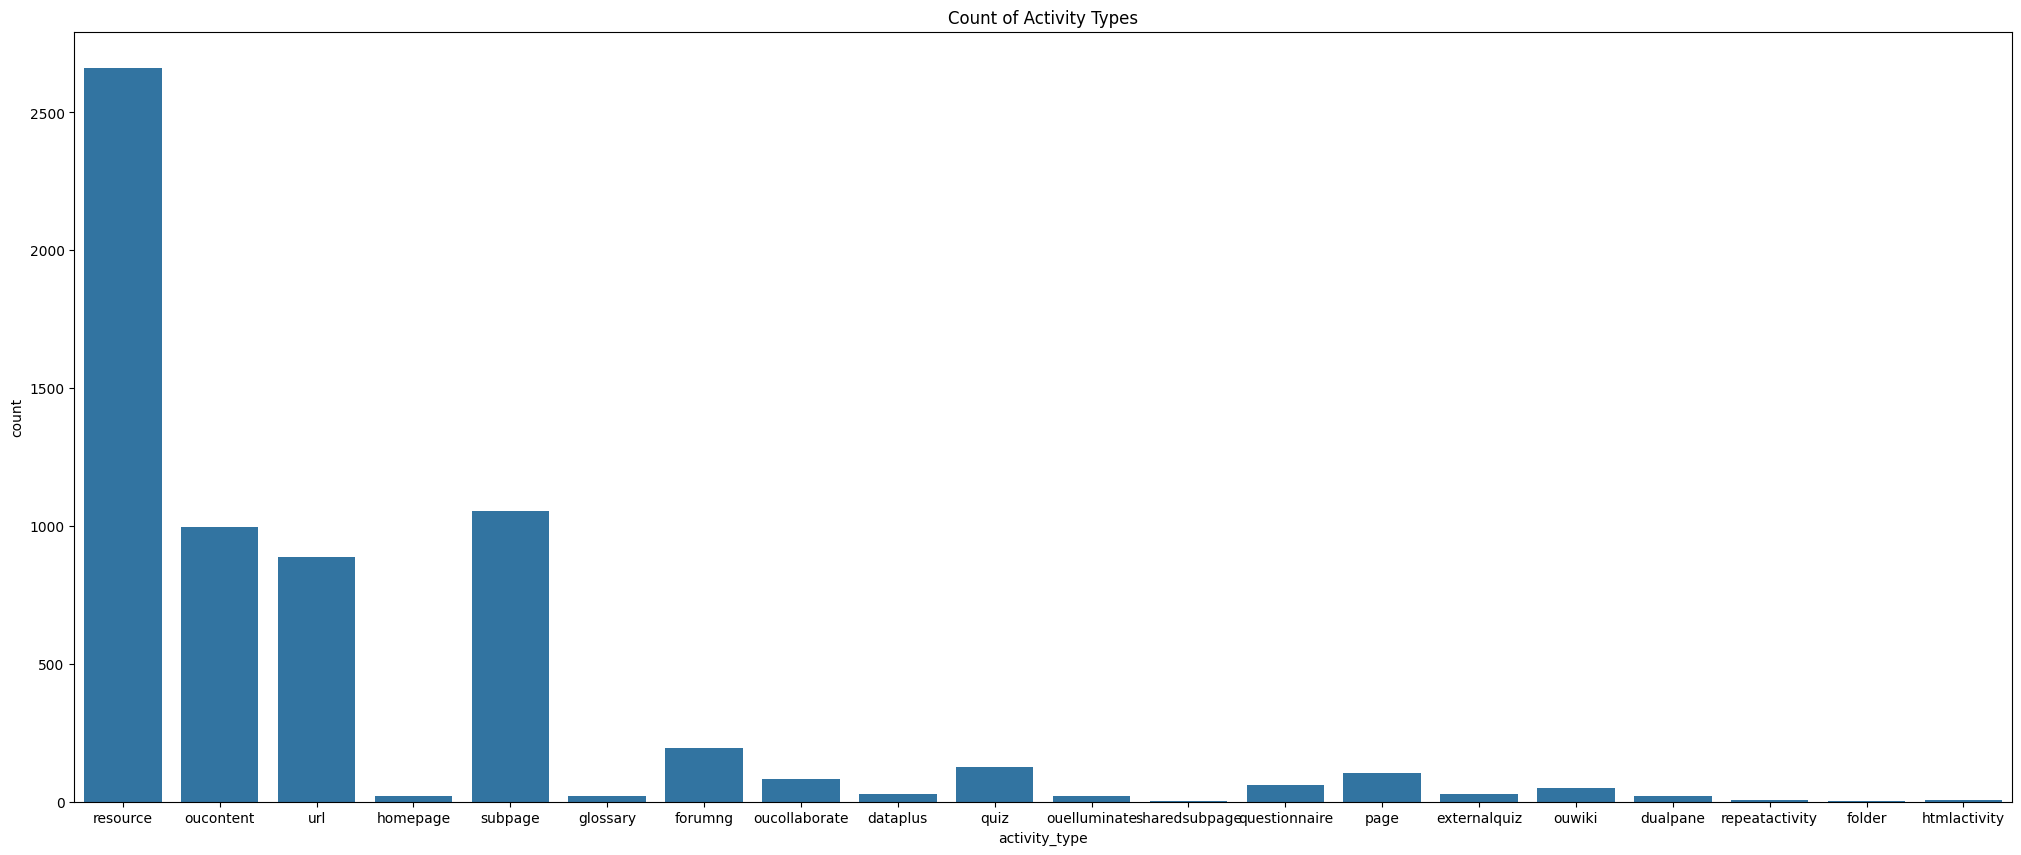

In [37]:
### Dari sini kita bisa melihat bahwa tipe aktivitas paling banyak pada LMS adalah 'Resources'

# Set ukuran plot
plt.figure(figsize=(25, 10))

# Membuat countplot
sns.countplot(data=oulad_vle, x='activity_type')

# Menambahkan judul
plt.title('Count of Activity Types')

# Menampilkan plot
plt.show()

# INTEGRASI DATA

#### Disini kita akan mulai Integrasi Data berdasarkan tabel yang ada pada website OULAD

Database schema.png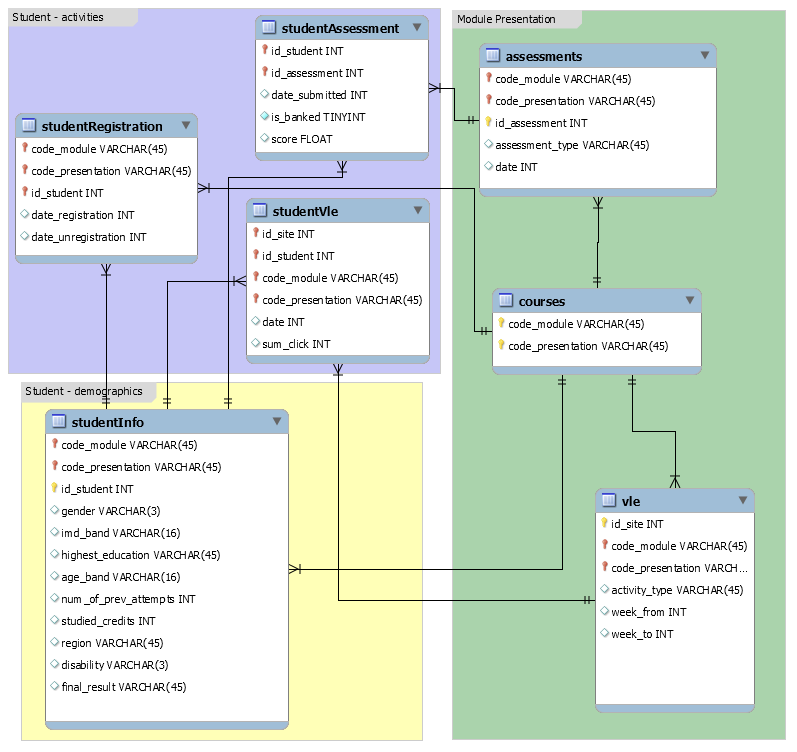

### Langkah pertama kita bisa gabungkan tabel student vle dan vle. Dari sini seharusnya kita bisa melihat interaksi siswa dengan LMS.

In [38]:
student_vle_merge_vle = oulad_student_vle.merge(oulad_vle, 
                                                on=['id_site', 'code_module', 'code_presentation'],
                                                how = 'left')

Dari merge tabel di bawah bisa dilihat bahwa tabel menggambarkan bahwa dalam data atau studi yang sedang dilakukan, terlihat bahwa ada banyak interaksi yang dilakukan oleh seorang siswa sebelum kursus dimulai. Dalam konteks ini, "interaksi" merujuk pada aktivitas atau keterlibatan siswa dalam bahan atau materi kursus sebelum kursus tersebut secara resmi dimulai.

Pernyataan tersebut kemudian mengusulkan dua hal:

Asumsi tentang Minat Siswa: Asumsi dibuat bahwa jika seorang siswa tertarik dalam kursus tersebut, maka mereka akan berinteraksi dengan materi kursus sebelum kursus dimulai. Dengan kata lain, siswa yang aktif berinteraksi dengan materi sebelum kursus dimulai kemungkinan besar memiliki minat yang tinggi dalam kursus tersebut.

Jumlah Klik Sebelum dan Setelah Kursus Dimulai: Untuk mengukur minat dan keterlibatan siswa, jumlah klik (interaksi) yang dilakukan oleh siswa sebelum dan setelah kursus dimulai akan dihitung. Ini akan memberikan informasi tentang seberapa aktif siswa dalam memeriksa materi sebelum kursus dimulai (misalnya, materi prakursus atau informasi kursus pra-awal) dan seberapa aktif mereka selama kursus berlangsung.

Dengan mengamati jumlah klik sebelum dan setelah kursus dimulai, penelitian atau analisis ini berusaha untuk menentukan apakah ada korelasi antara tingkat keterlibatan awal siswa dengan hasil akhir atau kinerja mereka dalam kursus. Dalam beberapa konteks, tingkat keterlibatan awal dapat digunakan sebagai faktor penting untuk memprediksi apakah seorang siswa akan berhasil atau tidak dalam kursus tersebut.

In [39]:
student_vle_merge_vle[(student_vle_merge_vle['id_student']==28400) & (student_vle_merge_vle['date']<0)].head(10)

,code_module,code_presentation,id_student,id_site,date,sum_click,activity_type
0,AAA,2013J,28400,546652,-10,4,forumng
1,AAA,2013J,28400,546652,-10,1,forumng
2,AAA,2013J,28400,546652,-10,1,forumng
3,AAA,2013J,28400,546614,-10,11,homepage
4,AAA,2013J,28400,546714,-10,1,oucontent
5,AAA,2013J,28400,546652,-10,8,forumng
6,AAA,2013J,28400,546876,-10,2,subpage
7,AAA,2013J,28400,546688,-10,15,oucontent
8,AAA,2013J,28400,546662,-10,17,oucontent
9,AAA,2013J,28400,546890,-10,1,url


In [40]:
student_vle_merge_vle['Click_Timing'] = ['Before' if date < 0 else 'After' for date in student_vle_merge_vle['date']]

In [41]:
# Kita membuat fitur after dan before click berdasarkan data click timing yang sudah dijalankan di kode di cell atas

student_vle_merge_vle['After_Clicks'] = np.where(student_vle_merge_vle['Click_Timing'] =='After',
                                                 student_vle_merge_vle['sum_click'], 0)

student_vle_merge_vle['Before_Clicks']= np.where(student_vle_merge_vle['Click_Timing'] =='Before',
                                                 student_vle_merge_vle['sum_click'], 0)

In [42]:
# Membuat dataframe baru dengan fitur fitur yang telah dikelompokkan berdasarkan kolom

student_vle_merge_vle_grouped = student_vle_merge_vle.groupby(['code_module', 'code_presentation', 'id_student'], as_index=False).agg({
    'sum_click': 'sum',
    'After_Clicks': 'sum',
    'Before_Clicks': 'sum'
})

# Menampilkan hasil
print(student_vle_merge_vle_grouped)

      code_module code_presentation  id_student  sum_click  After_Clicks  \
0             AAA             2013J       11391        934           836   
1             AAA             2013J       28400       1435          1220   
2             AAA             2013J       30268        281           179   
3             AAA             2013J       31604       2158          1989   
4             AAA             2013J       32885       1034           739   
...           ...               ...         ...        ...           ...   
29223         GGG             2014J     2640965         41            39   
29224         GGG             2014J     2645731        893           893   
29225         GGG             2014J     2648187        312           297   
29226         GGG             2014J     2679821        275           210   
29227         GGG             2014J     2684003        616           501   

       Before_Clicks  
0                 98  
1                215  
2                1

In [43]:
student_vle_merge_vle_grouped.isnull().sum()

code_module          0
code_presentation    0
id_student           0
sum_click            0
After_Clicks         0
Before_Clicks        0
dtype: int64

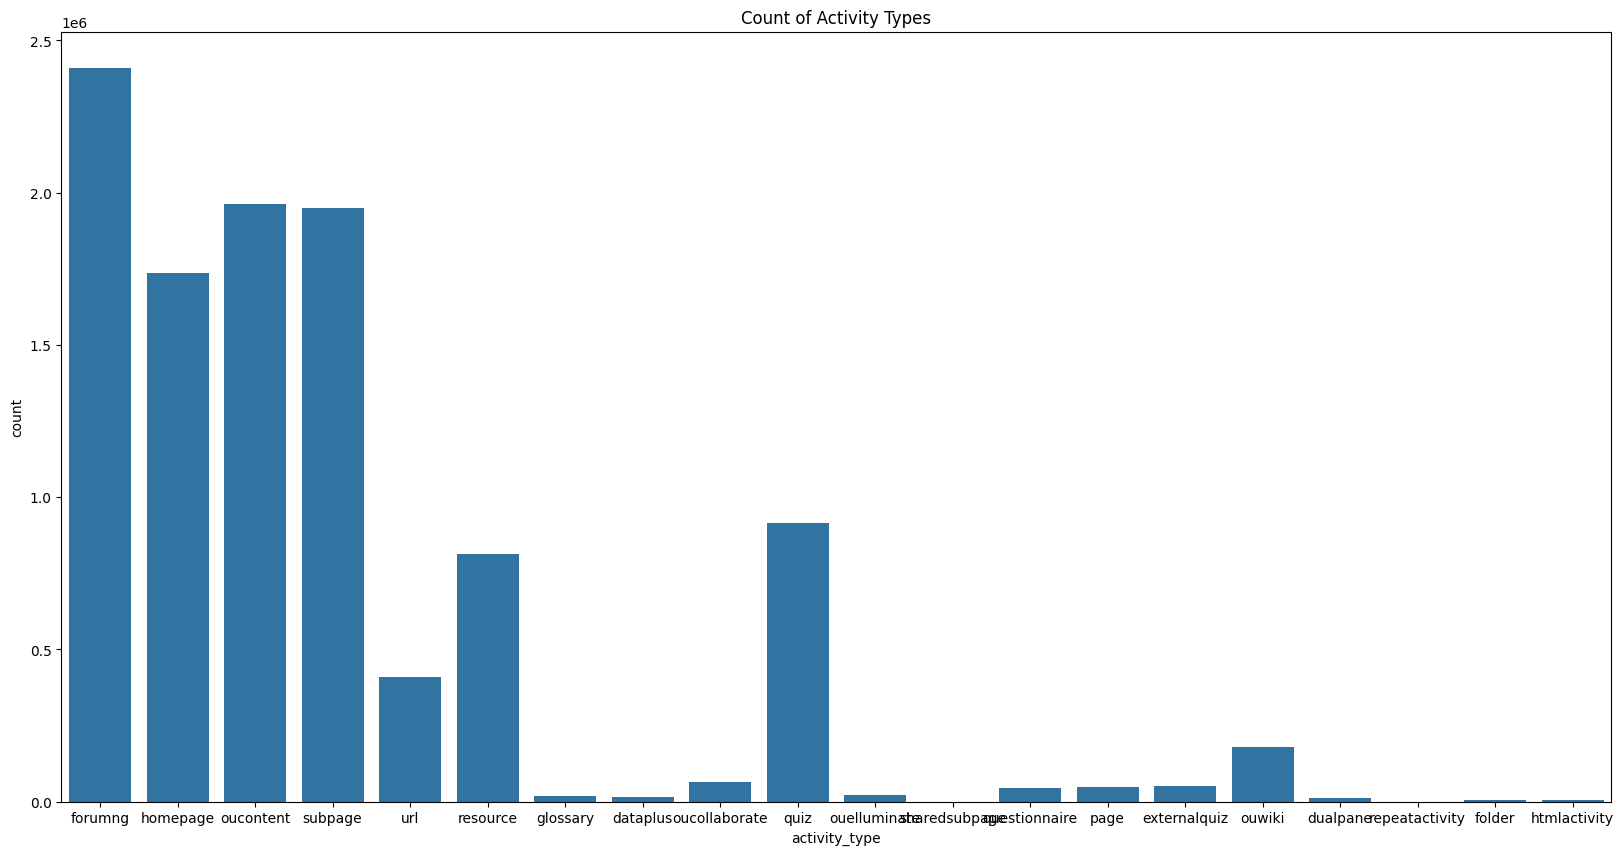

In [44]:
### Plot dibawah akan memperlihatkan cara apa yang digunakan siswa untuk mengakses VLE
### Kita bisa lihat bahwa paling banyak melalui ForumNG (Open University Forum Platform),
### oucontent (Open University Content), subpage dan homepage.

# Set ukuran plot
plt.figure(figsize=(20, 10))

# Membuat countplot
sns.countplot(data=student_vle_merge_vle, x='activity_type')

# Menambahkan judul
plt.title('Count of Activity Types')

# Menampilkan plot
plt.show()

<Axes: xlabel='activity_type'>

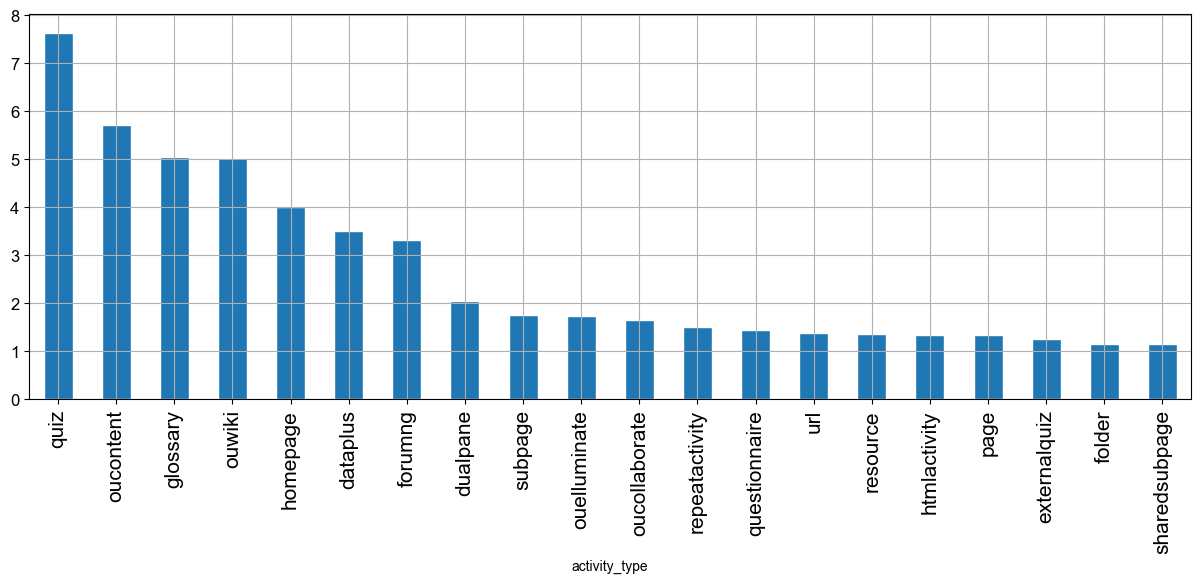

In [45]:
plt.figure(figsize = (15, 5))
plt.xticks(rotation=90, fontsize=15)
plt.yticks(rotation=0, fontsize=12)
sns.set_style("whitegrid")
student_vle_merge_vle.groupby(['activity_type'], as_index=True)['sum_click'].mean().sort_values(ascending=False).plot(kind='bar')


Plot tersebut menggambarkan rata-rata interaksi siswa dengan setiap jenis aktivitas atau tipe aktivitas yang tersedia dalam data. Plot ini bertujuan untuk memberikan pemahaman tentang seberapa sering siswa berinteraksi dengan berbagai jenis aktivitas dalam lingkungan pembelajaran online atau platform pembelajaran.

Berikut adalah penjelasan satu per satu:

Interaksi dengan QUIZ: Pada plot, terlihat bahwa ada tingkat interaksi yang tinggi dengan jenis aktivitas "QUIZ." Ini bisa dimengerti karena siswa umumnya berinteraksi dengan kuis setelah belajar sesuatu. Kuis dapat digunakan untuk menguji pemahaman siswa terhadap materi yang baru dipelajari.

Interaksi dengan OUCONTENT: Terlihat bahwa aktivitas "OUCONTENT" juga memiliki tingkat interaksi yang tinggi. Ini bisa dimengerti karena siswa sering berinteraksi dengan konten atau materi pembelajaran untuk memahami materi yang diajarkan.

Interaksi dengan GLOSSARY: Aktivitas "GLOSSARY" juga memiliki tingkat interaksi yang tinggi. Ini menunjukkan bahwa siswa sering menggunakan glosarium untuk memahami istilah atau kata-kata kunci dalam materi pembelajaran. Glosarium dapat membantu mereka memahami dengan lebih baik apa yang diajarkan.

Interaksi dengan OUWIKI: Aktivitas "OUWIKI" juga menunjukkan tingkat interaksi yang tinggi. Ini mungkin karena siswa menggunakan wiki untuk mendapatkan informasi tambahan atau mendalam tentang topik tertentu.

Secara keseluruhan, plot ini membantu dalam memahami pola interaksi siswa dengan berbagai jenis aktivitas dalam lingkungan pembelajaran online, dan interpretasi tersebut memberikan beberapa pemahaman tentang bagaimana siswa memanfaatkan sumber daya pembelajaran yang tersedia untuk mereka.

In [46]:
student_vle_merge_vle.head()

,code_module,code_presentation,id_student,id_site,date,sum_click,activity_type,Click_Timing,After_Clicks,Before_Clicks
0,AAA,2013J,28400,546652,-10,4,forumng,Before,0,4
1,AAA,2013J,28400,546652,-10,1,forumng,Before,0,1
2,AAA,2013J,28400,546652,-10,1,forumng,Before,0,1
3,AAA,2013J,28400,546614,-10,11,homepage,Before,0,11
4,AAA,2013J,28400,546714,-10,1,oucontent,Before,0,1


###### Disini kita coba merge tabel studentRegistration dengan tabel courses untuk mengetahuin korelasi antara registrasi dan panjang course(durasinya)

In [47]:
student_registration_merge_courses = oulad_student_registration.merge(oulad_courses, 
                                                                      on = ['code_module', 'code_presentation'],
                                                                      how = 'left')

In [48]:
student_registration_merge_courses['Year'] = student_registration_merge_courses['code_presentation'].str[0:4]
student_registration_merge_courses['Starting_Month'] = ['February' if code[-1] == 'B' else 'October' 
                                                        for code in student_registration_merge_courses['code_presentation']]

In [49]:
student_registration_merge_courses

,code_module,code_presentation,id_student,date_registration,date_unregistration,module_presentation_length,Year,Starting_Month
0,AAA,2013J,11391,159.0,0,268,2013,October
1,AAA,2013J,28400,53.0,0,268,2013,October
2,AAA,2013J,30268,92.0,1,268,2013,October
3,AAA,2013J,31604,52.0,0,268,2013,October
4,AAA,2013J,32885,176.0,0,268,2013,October
...,...,...,...,...,...,...,...,...
32588,GGG,2014J,2640965,4.0,0,269,2014,October
32589,GGG,2014J,2645731,23.0,0,269,2014,October
32590,GGG,2014J,2648187,129.0,0,269,2014,October
32591,GGG,2014J,2679821,49.0,1,269,2014,October


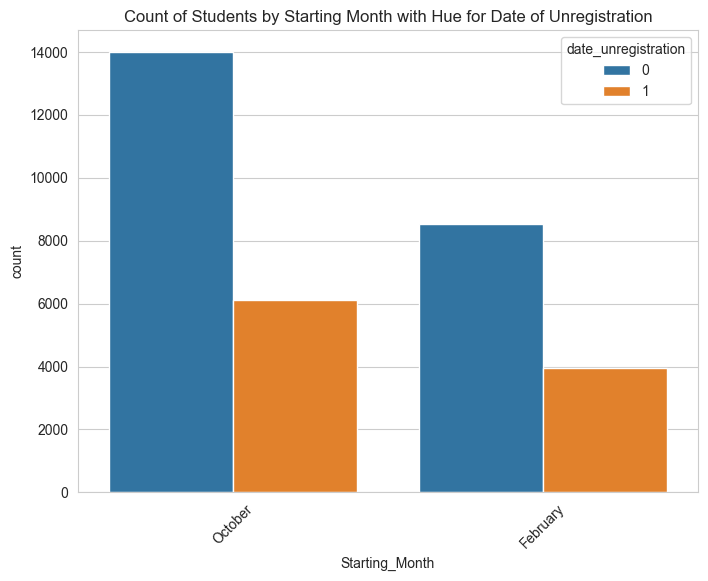

In [50]:
# Plot ini menggambarkan bahwa di bulan oktober adalah bulan paling banyak siswa melakuka registrasi dan pengunduran diri
# Set ukuran plot
plt.figure(figsize=(8, 6))

# Membuat countplot
sns.countplot(data=student_registration_merge_courses, x='Starting_Month', hue='date_unregistration')

# Menambahkan judul
plt.title('Count of Students by Starting Month with Hue for Date of Unregistration')

# Menampilkan plot
plt.xticks(rotation=45)
plt.show()


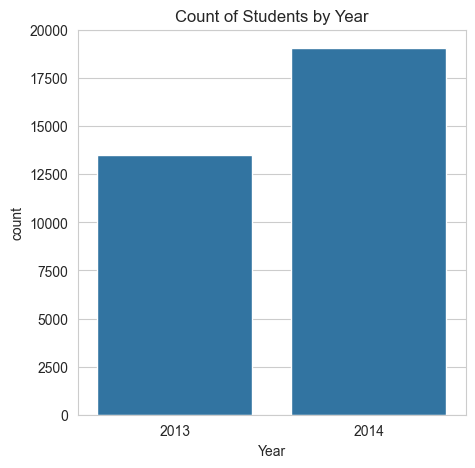

In [51]:
### Tahun 2014 terjadi peningkatan pada jumlah siswa yang mendaftar

# Set ukuran plot
plt.figure(figsize=(5, 5))

# Membuat countplot
sns.countplot(data=student_registration_merge_courses, x='Year')

# Menambahkan judul
plt.title('Count of Students by Year')

# Menampilkan plot
plt.show()

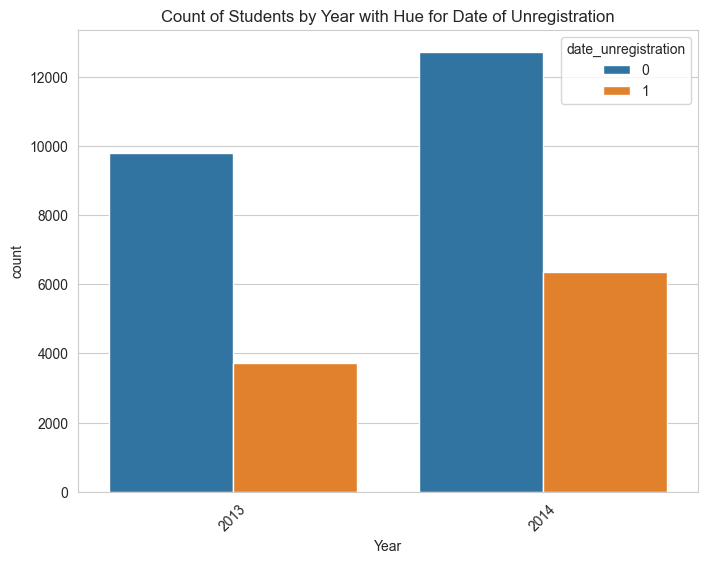

In [52]:
# Dan di tahun 2014 juga banyak yang menyelesaikan coursenya

# Set ukuran plot
plt.figure(figsize=(8, 6))

# Membuat countplot dengan hue
sns.countplot(data=student_registration_merge_courses, x='Year', hue='date_unregistration')

# Menambahkan judul
plt.title('Count of Students by Year with Hue for Date of Unregistration')

# Menampilkan plot
plt.xticks(rotation=45)
plt.show()



In [53]:
# terlihat bahwa tidak ada perbedaan yang signifikan dalam durasi atau panjang kursus antara siswa yang menarik diri (withdrawn)
# dan siswa yang menyelesaikan (completed) kursus pada tabel di bawah ini.

student_registration_merge_courses.groupby('date_unregistration', as_index=False)['module_presentation_length'].mean()

,date_unregistration,module_presentation_length
0,0,256.095378
1,1,255.819500


###### Sekarang waktunya integrasi antara merge assessments Table dan studentAssessment Table untuk mengetahui korelasi antara assesment dan student performance

In [54]:
student_assessment_merge_assessment = oulad_student_assessment.merge(oulad_assessment,
                                                                     on = ['id_assessment'], how='left' )

In [55]:
student_assessment_merge_assessment.dtypes

id_assessment          int64
id_student             int64
date_submitted         int64
is_banked              int64
score                float64
code_module           object
code_presentation     object
assessment_type       object
date                 float64
weight               float64
dtype: object

Code di bawah ini akan mengevaluasi apakah mahasiswa telah mengumpulkan tugas mereka terlambat atau tepat waktu berdasarkan dua kolom dalam data, yaitu "date_submitted" (hari setelah mahasiswa menerima tugas mereka) dan "date" (batas waktu pengumpulan dalam hari untuk tugas tersebut). Setelah evaluasi ini, kita akan menentukan apakah pengumpulan tugas tersebut terlambat atau tepat waktu, dengan menggunakan label 0 untuk tugas yang terlambat dan label 1 untuk tugas yang tepat waktu.

Jadi, ini adalah langkah untuk mengkategorikan pengumpulan tugas mahasiswa dalam dua kategori, yakni "terlambat" atau "tepat waktu," berdasarkan perbandingan antara tanggal pengumpulan dan batas waktu yang telah ditentukan

In [56]:
student_assessment_merge_assessment['Late_submission'] = ['0' if int(student_assessment_merge_assessment['date_submitted'].iloc[i]) 
                                                          > int(student_assessment_merge_assessment['date'].iloc[i]) else '1' 
                                                         for i in range(len(student_assessment_merge_assessment))]


In [57]:
print('Persentase Mahasiswa yang terlambat mengumpulkan: ')
print((len(student_assessment_merge_assessment[student_assessment_merge_assessment['Late_submission']=='0'])/len(student_assessment_merge_assessment)*100))

Persentase Mahasiswa yang terlambat mengumpulkan: 
29.958155624240963


Late_submission                          0          1
assessment_type assessment_type                      
CMA             CMA              46.777830  53.222170
Exam            Exam             57.914902  42.085098
TMA             TMA              16.473797  83.526203


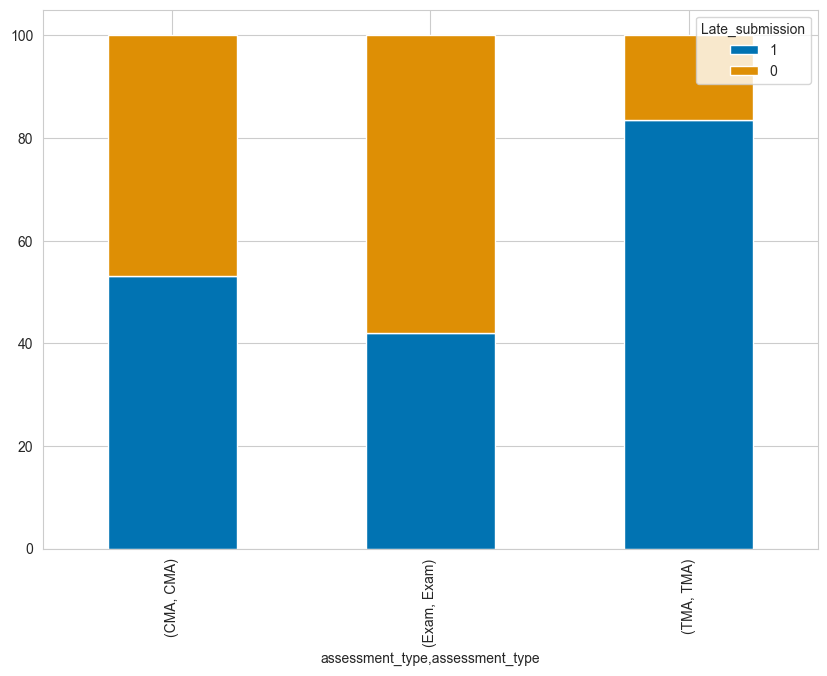

In [58]:
# Ada 3 tipe penilaian di dalam modul :- Tutor Marked Assessment (TMA/Dosen), Computer Marked Assessment (CMA), Exams
# Plot di bawah akan menunjukkan berapa banyak keterlambatan pengumpulan berdasarkan tipe penilaian

stacked_plot(student_assessment_merge_assessment, 'assessment_type', 'Late_submission', 'id_student', plot_size=(10, 7))



Plot di atas menunjukkan bahwa keterlambatan pengumpulan banyak ditemui pada CMA dan Exam

Late_submission                  0          1
code_module code_module                      
AAA         AAA          25.810553  74.189447
BBB         BBB          47.472021  52.527979
CCC         CCC          69.063342  30.936658
DDD         DDD          30.566283  69.433717
EEE         EEE          14.544763  85.455237
FFF         FFF          10.345268  89.654732
GGG         GGG          10.049293  89.950707


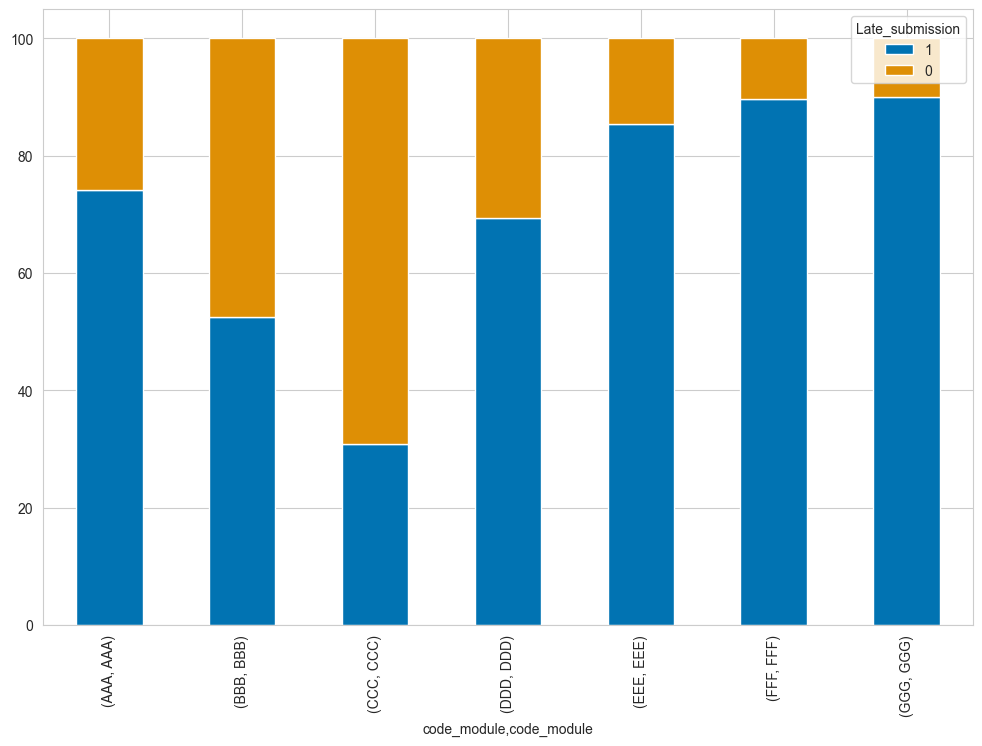

In [59]:
# Dataset mempunyai 7 code module. 4 modul untuk STEM dan 3 untuk Social Sciences
# Social Sciences :- AAA, BBB, GGG
# STEM :- CCC, DDD, EEE, FFF
# Dapat dilihat dari plot di bawah ini bahwa keterlambatan pengumpulan banyak terjadi di Course BBB, CCC dan DDD


stacked_plot(student_assessment_merge_assessment, 'code_module', 'Late_submission', 'id_student', plot_size=(12, 8))

In [60]:
## Buatkan kolom tersendiri untuk modul Social Science dan STEM

student_assessment_merge_assessment['Code_Category'] = ['Social_Science' if student_assessment_merge_assessment['code_module'].iloc[i] in ['AAA', 'BBB', 'GGG']
                                                        else 'STEM' for i in range(len(student_assessment_merge_assessment))]


Late_submission                        0          1
Code_Category  Code_Category                       
STEM           STEM            26.072296  73.927704
Social_Science Social_Science  37.078578  62.921422


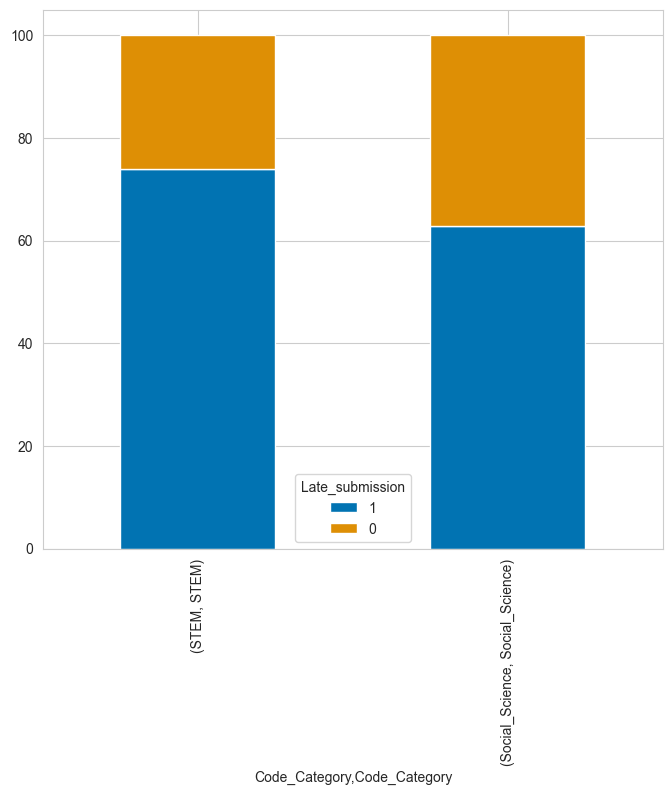

In [61]:
## Social Science mempunya persentasi keterlambatan pengumpulan lebih banyak daripada mahasiswa STEM


stacked_plot(student_assessment_merge_assessment, 'Code_Category', 'Late_submission', 'id_student', plot_size=(8, 7))

In [62]:
# Kita buatkan kolom result(lulus atau tidaknya) berdasarkan deskripsi pada tabel OULAD jika siswa mendapat nilai >40 maka lulus


student_assessment_merge_assessment['Result'] = ['Fail' if int(student_assessment_merge_assessment['score'].iloc[i]) < 40
                                                        else 'Pass' for i in range(len(student_assessment_merge_assessment))]

Result                             Fail       Pass
Code_Category  Code_Category                      
STEM           STEM            5.132608  94.867392
Social_Science Social_Science  2.949136  97.050864


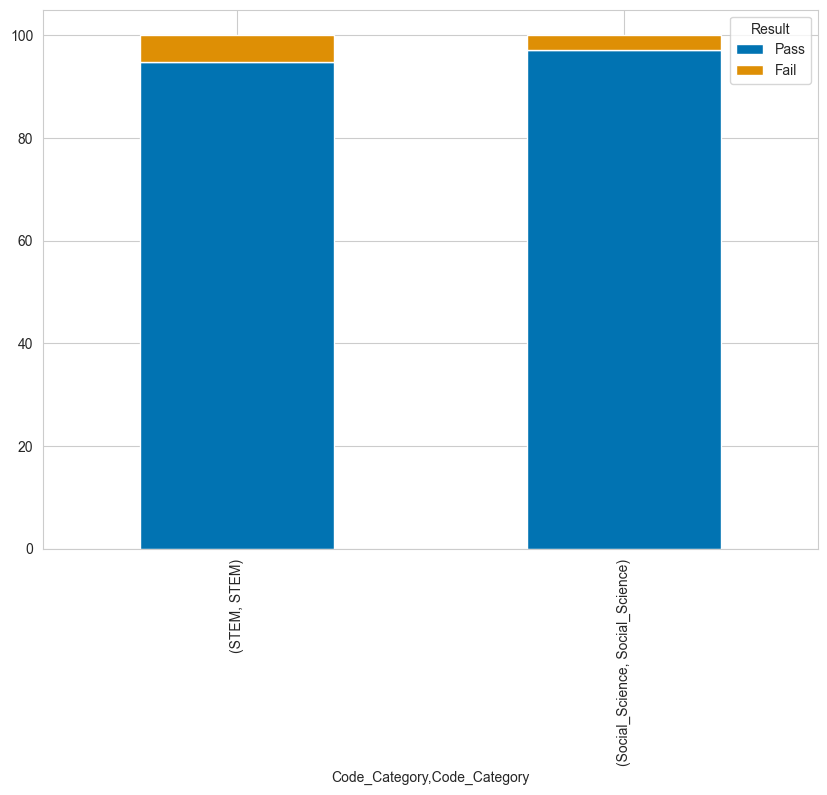

In [63]:
# Plot di bawah akan menunjukkan rasio murid lulus atau tidak pada masing masing domain
# Bisa dilihat bahwa kegagalan di domain STEM lebih banyak

stacked_plot(student_assessment_merge_assessment, 'Code_Category', 'Result', 'id_student', plot_size=(10, 7))

Result                       Fail       Pass
code_module code_module                     
AAA         AAA          2.860776  97.139224
BBB         BBB          3.306266  96.693734
CCC         CCC          9.297903  90.702097
DDD         DDD          9.044297  90.955703
EEE         EEE          1.775298  98.224702
FFF         FFF          1.975570  98.024430
GGG         GGG          1.958593  98.041407


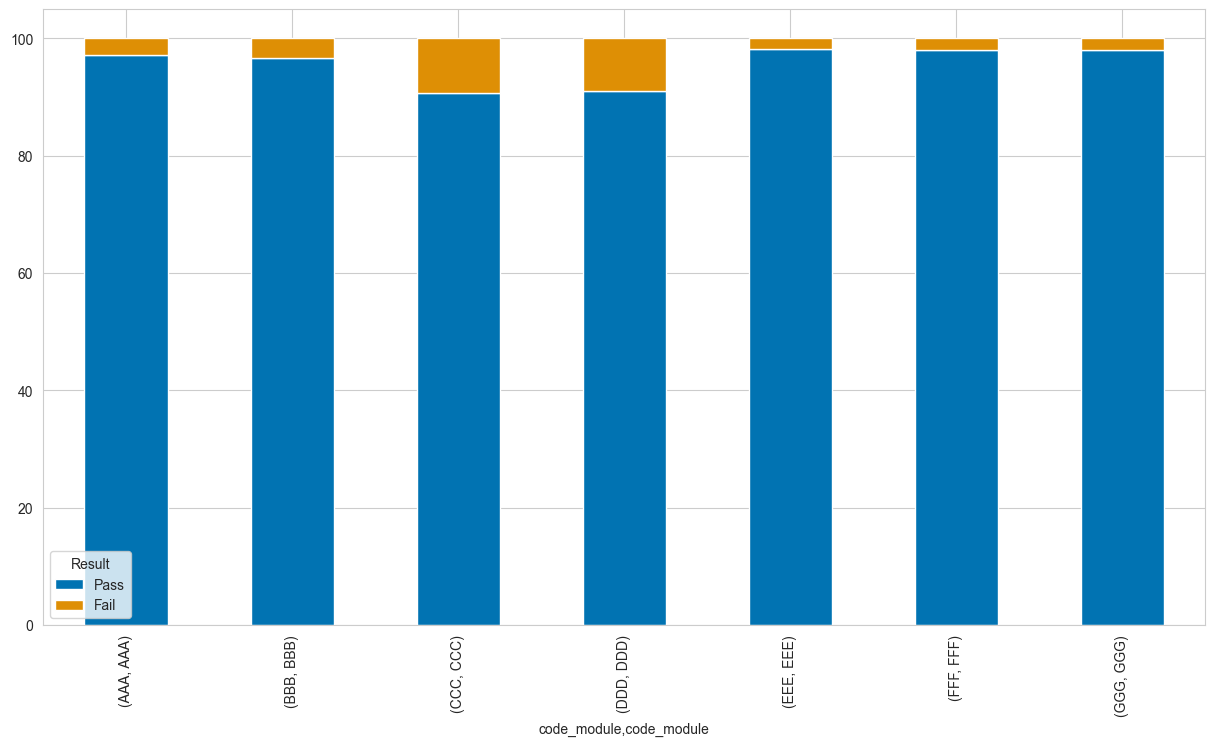

In [64]:
# Dari plot di bawah kita juga bisa melihat bahwa modul DDD , CCC and BBB mempunyai persentase kegagalan tinggi.
# Dan dari 3 modul tersebut 2 di antaranya berasal dari domain STEM


stacked_plot(student_assessment_merge_assessment, 'code_module', 'Result', 'id_student', plot_size=(15, 8))

In [65]:
## Dalam assesment terdapat bobot penilaian dan dari bobot tersebut dapat mempengaruhi hasil akhir siswa. 
## Disini akan saya buat 3 kategori bobot pada penilaian assesment yang ada

print(student_assessment_merge_assessment['weight'].unique())

percentage_segment = []

for percent in student_assessment_merge_assessment['weight']:
    if percent <= 10:
        percentage_segment.append('Low_Weightage')
    elif percent > 10 and percent <= 30:
        percentage_segment.append('Medium_Weightage')
    else:
        percentage_segment.append('High_Weightage')
        
student_assessment_merge_assessment['Weigthage'] = percentage_segment

[ 10.   20.   30.    5.   18.    1.    0.   35.    9.   22.    2.    7.
   8.  100.    7.5  12.5  15.    3.    4.    6.   17.5  25.   16.   28. ]


Result                                 Fail       Pass
Weigthage        Weigthage                            
High_Weightage   High_Weightage    8.463783  91.536217
Low_Weightage    Low_Weightage     3.329021  96.670979
Medium_Weightage Medium_Weightage  5.307333  94.692667


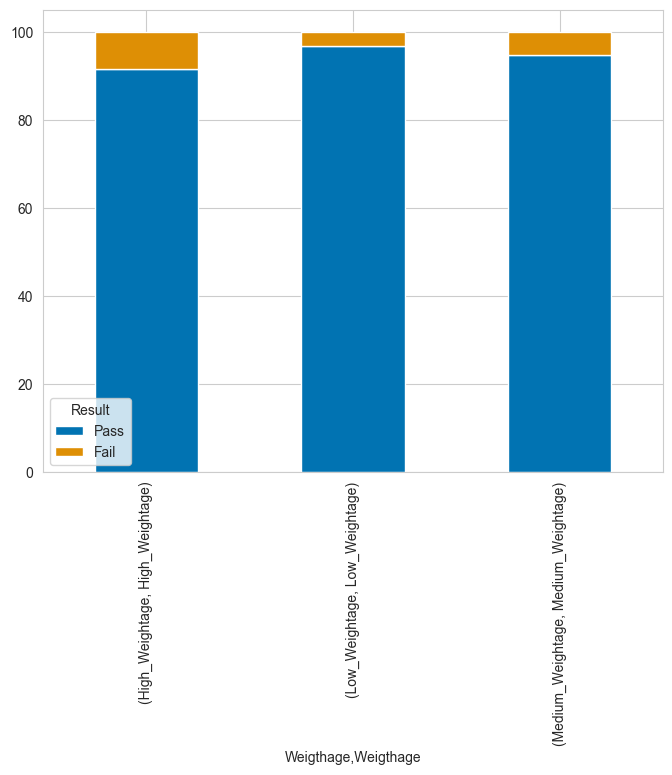

In [66]:
# Kita cari tahu di mana bobot penilaian yang mempunya persentase gagal paling tinggi

stacked_plot(student_assessment_merge_assessment, 'Weigthage', 'Result', 'id_student', plot_size=(8, 6))

Result                               Fail       Pass
Late_submission Late_submission                     
0               0                6.841630  93.158370
1               1                3.301011  96.698989


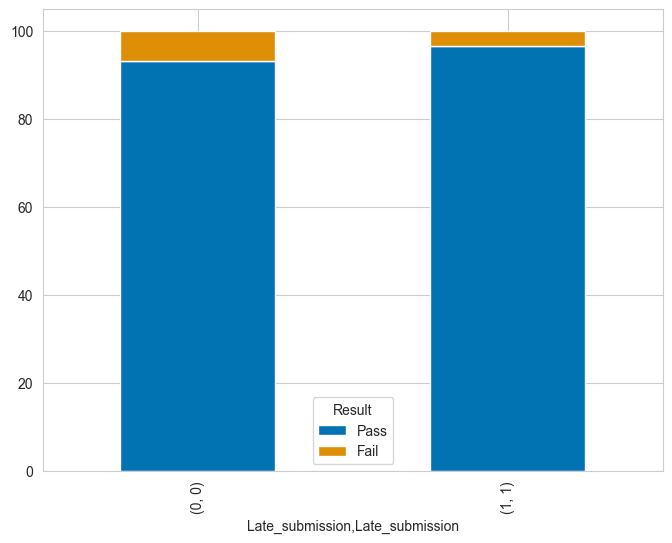

In [67]:
# Disini kita juga akan mencari tahu hasil akhir berdasarkan terlambat atau tidaknya pengumpulan
stacked_plot(student_assessment_merge_assessment, 'Late_submission', 'Result', 'id_student', plot_size=(8, 6))

Maka bisa terlihat dari plot diatas bahwasanya siswa yang mengumpulkan terlambat  mempunyai rasio gagal yang lebih tinggi walaupun persentasi lulusnya juga tinggi

In [68]:
student_assessment_merge_assessment.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight,Late_submission,Code_Category,Result,Weigthage
0,1752,11391,18,0,78.0,AAA,2013J,TMA,19.0,10.0,1,Social_Science,Pass,Low_Weightage
1,1752,28400,22,0,70.0,AAA,2013J,TMA,19.0,10.0,0,Social_Science,Pass,Low_Weightage
2,1752,31604,17,0,72.0,AAA,2013J,TMA,19.0,10.0,1,Social_Science,Pass,Low_Weightage
3,1752,32885,26,0,69.0,AAA,2013J,TMA,19.0,10.0,0,Social_Science,Pass,Low_Weightage
4,1752,38053,19,0,79.0,AAA,2013J,TMA,19.0,10.0,1,Social_Science,Pass,Low_Weightage


###### Integrasi VLE DATA Dengan STUDENT INFO DATA

In [69]:
student_info = oulad_student_info.merge(student_vle_merge_vle, 
                                        on = ['code_module', 'code_presentation', 'id_student'],
                                        how = 'left')

student_info['sum_click']     = student_info['sum_click'].fillna(student_info['sum_click'].mean())
student_info['After_Clicks']  = student_info['After_Clicks'].fillna(student_info['After_Clicks'].mean())
student_info['Before_Clicks'] = student_info['Before_Clicks'].fillna(student_info['Before_Clicks'].mean())

<Axes: xlabel='final_result'>

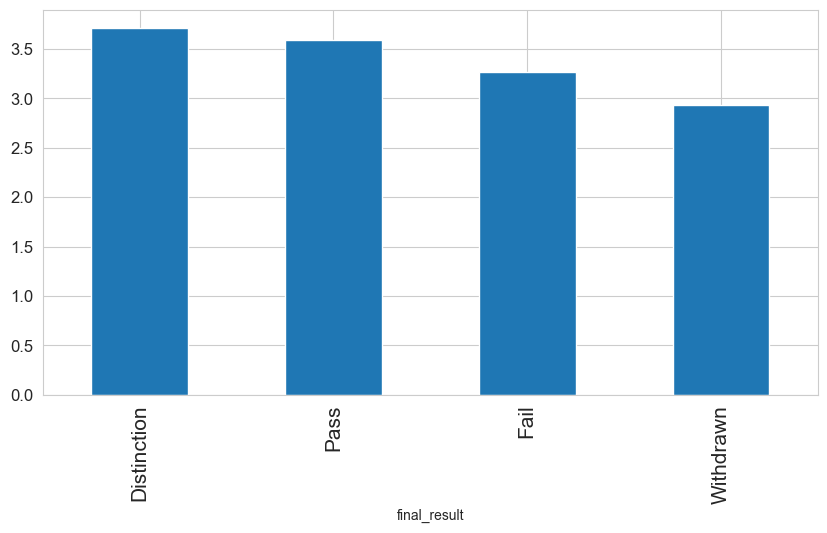

In [70]:
# Dalam plot ini, kita mencoba untuk memeriksa hubungan antara jumlah klik dengan hasil akademis.
# Dari plot tersebut, kita dapat melihat dengan jelas bahwa jumlah klik berkaitan langsung dengan hasil akademis.
# Siswa yang lulus dengan predikat "Distinction" memiliki jumlah klik yang signifikan lebih tinggi dibandingkan dengan siswa 
## yang mendapatkan hasil "PASS,"
# dan terdapat perbedaan besar antara siswa yang gagal atau menarik diri dibandingkan dengan siswa yang lulus baik dengan 
## atau tanpa predikat "Distinction."

plt.figure(figsize = (10, 5))
plt.xticks(rotation=90, fontsize=15)
plt.yticks(rotation=0, fontsize=12)
sns.set_style("whitegrid")
student_info.groupby(['final_result'])['After_Clicks'].mean().sort_values(ascending = False).plot(kind='bar')

<Axes: xlabel='final_result'>

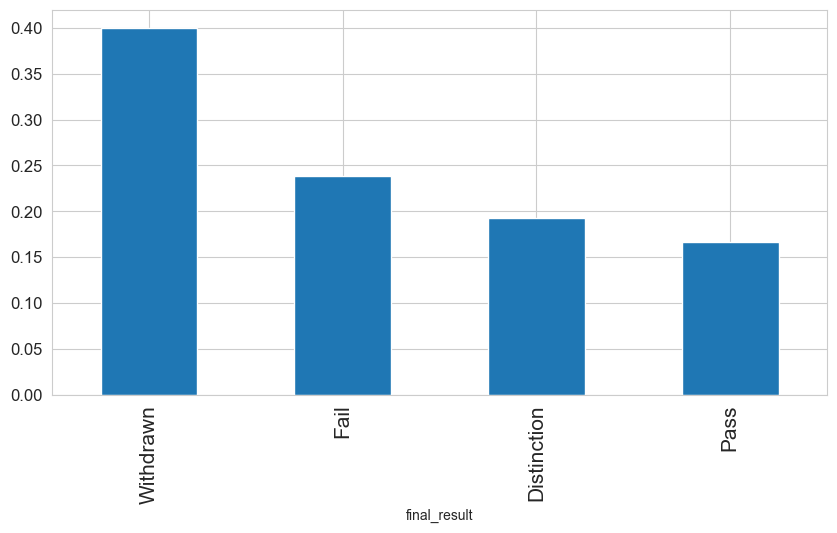

In [71]:
## Bahkan dari data "clicks" sebelum course dimulai, kita dapat melihat bahwa siswa yang melakukan click lebih banyak
## berakhir dengan hasil distinction dan pass

plt.figure(figsize = (10, 5))
plt.xticks(rotation=90, fontsize=15)
plt.yticks(rotation=0, fontsize=12)
sns.set_style("whitegrid")
student_info.groupby(['final_result'])['Before_Clicks'].mean().sort_values(ascending = False).plot(kind='bar')

<Axes: xlabel='final_result'>

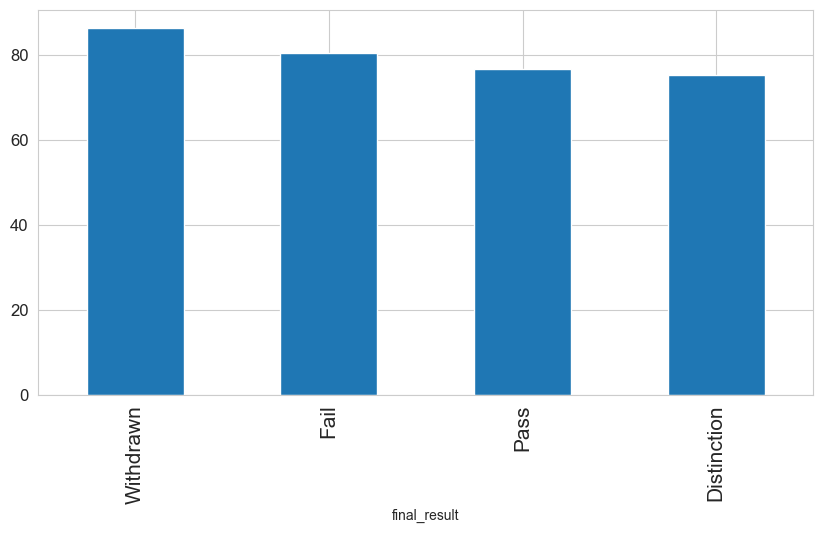

In [72]:
# Orang dengan jumlah kredit yang lebih sedikit memiliki lebih banyak peluang untuk lulus dengan predikat "Distinction" 
# atau "Pass" karena mereka harus belajar lebih sedikit.
# Orang yang mengundurkan diri memiliki rata-rata jumlah kredit yang lebih tinggi dibandingkan dengan yang lain.

plt.figure(figsize = (10, 5))
plt.xticks(rotation=90, fontsize=15)
plt.yticks(rotation=0, fontsize=12)
sns.set_style("whitegrid")
student_info.groupby(['final_result'])['studied_credits'].mean().sort_values(ascending = False).plot(kind='bar')

<Axes: xlabel='age_band'>

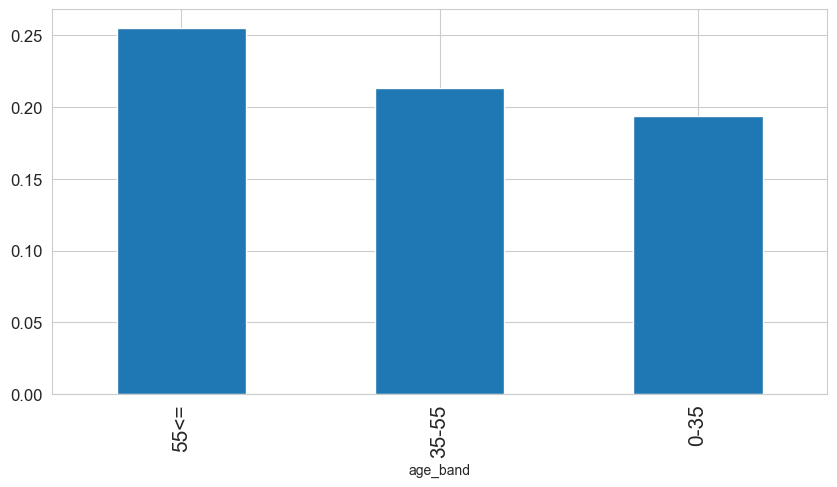

In [73]:
# Jumlah rata rata klik sebelum course dimulai berdasarkan rentang usia
plt.figure(figsize = (10, 5))
plt.xticks(rotation=90, fontsize=15)
plt.yticks(rotation=0, fontsize=12)
sns.set_style("whitegrid")
student_info.groupby(['age_band'])['Before_Clicks'].mean().sort_values(ascending = False).plot(kind='bar')

<Axes: xlabel='imd_band'>

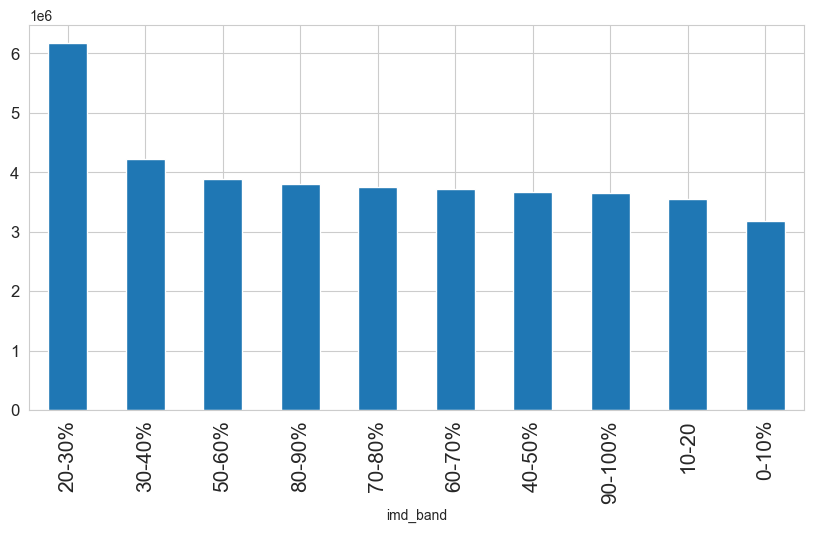

In [74]:
# jumlah clicks berdasarkan imd_band.

plt.figure(figsize = (10, 5))
plt.xticks(rotation=90, fontsize=15)
plt.yticks(rotation=0, fontsize=12)
sns.set_style("whitegrid")
student_info.groupby(['imd_band'])['sum_click'].sum().sort_values(ascending = False).plot(kind='bar')

<Axes: xlabel='gender'>

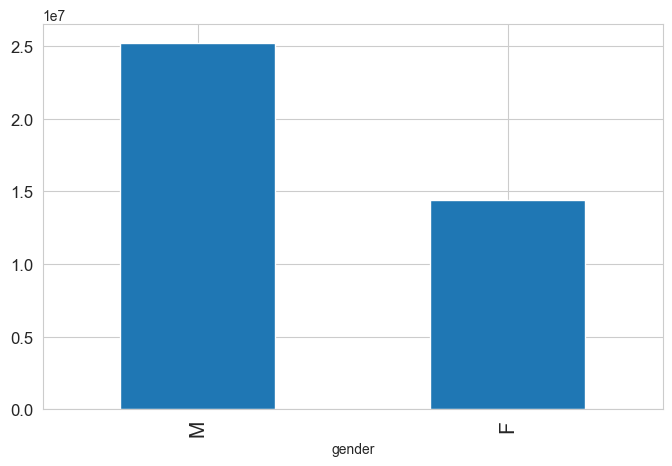

In [75]:
# Kita juga mengelompokkan jumlah klik berdasarkan gender
# Ternyata lelaki mempunyai jumlah klik yang jauh lebih banyak dibandingkan perempuan

plt.figure(figsize = (8, 5))
plt.xticks(rotation=90, fontsize=15)
plt.yticks(rotation=0, fontsize=12)
sns.set_style("whitegrid")
student_info.groupby(['gender'])['sum_click'].sum().sort_values(ascending = False).plot(kind='bar')

age_band  final_result
0-35      Pass            4027735
35-55     Pass            2218143
0-35      Distinction     1177710
          Fail             905124
35-55     Distinction      848642
0-35      Withdrawn        628298
35-55     Fail             399091
          Withdrawn        319523
55<=      Pass              76677
          Distinction       38677
          Withdrawn         11104
          Fail               7921
Name: id_student, dtype: int64
final_result       Distinction       Fail       Pass  Withdrawn
age_band age_band                                              
0-35     0-35        17.476380  13.431397  59.768727   9.323496
35-55    35-55       22.418826  10.542904  58.597337   8.440933
55<=     55<=        28.782027   5.894522  57.060255   8.263196


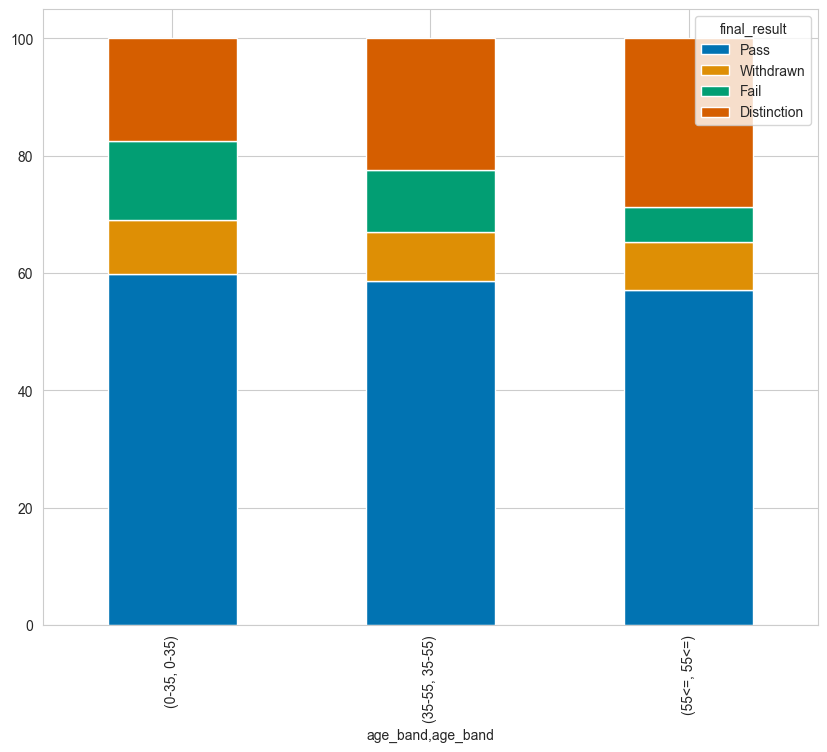

In [76]:
# Plot di bawah ini menunjukkan jumlah siswa dalam setiap kategori hasil. Sebagian besar data terdapat dalam kelompok usia 0-55.
# Terdapat sedikit data untuk usia >= 55.
# Kita dapat melihat bahwa tingkat kegagalan dan penarikan diri lebih tinggi dalam kelompok usia 0-35.

print(student_info.groupby(['age_band', 'final_result'])['id_student'].count().sort_values(ascending = False))
stacked_plot(student_info, 'age_band', 'final_result', 'id_student', plot_size=(10, 8))

final_result                                             Distinction  \
highest_education           highest_education                          
A Level or Equivalent       A Level or Equivalent          21.032926   
HE Qualification            HE Qualification               27.045620   
Lower Than A Level          Lower Than A Level             12.761488   
No Formal quals             No Formal quals                14.912935   
Post Graduate Qualification Post Graduate Qualification    39.424288   

final_result                                                  Fail       Pass  \
highest_education           highest_education                                   
A Level or Equivalent       A Level or Equivalent        10.840185  60.240532   
HE Qualification            HE Qualification              8.594011  56.930232   
Lower Than A Level          Lower Than A Level           16.184813  59.961416   
No Formal quals             No Formal quals              18.881119  53.041895   
Post Grad

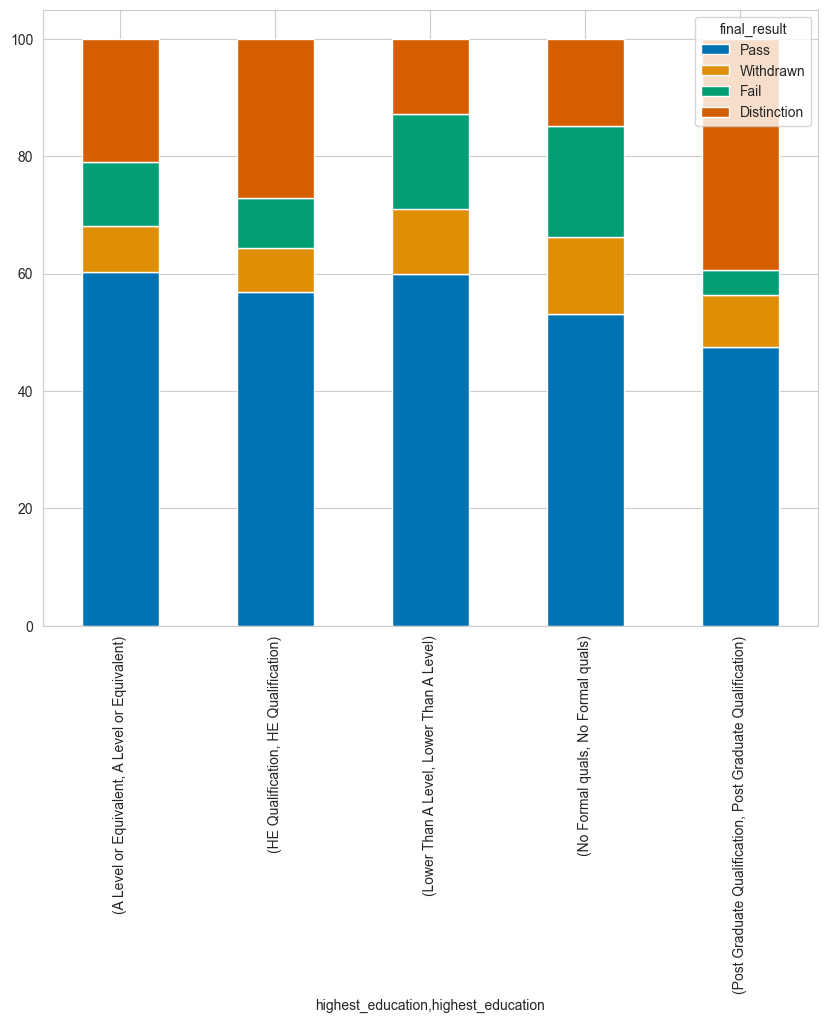

In [77]:
# Dari plot ini, kita dapat melihat bahwa Tingkat Kegagalan dan Tingkat Penarikan Diri tinggi pada orang-orang yang 
# Tidak memiliki pendidikan formal
# dan pada mereka yang memiliki pendidikan tingkat di bawah A Level(Lover Than A Level).
# Tingkat Kegagalan terendah terdapat pada orang-orang yang memiliki Pendidikan Pascasarjana(Post Graduate).



stacked_plot(student_info, 'highest_education', 'final_result', 'id_student', plot_size=(10, 8))

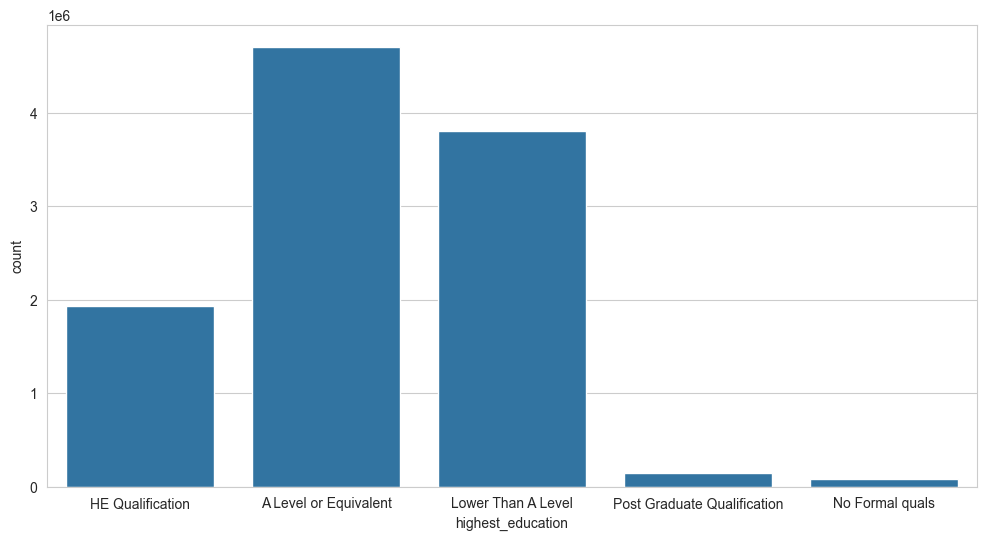

In [78]:
# Dari plot, kita dapat melihat bahwa sebagian besar data adalah untuk orang-orang yang memiliki tingkat pendidikan tingkat A 
# atau tingkat pendidikan yang lebih rendah.
# Hal ini akan menyebabkan ketidakseimbangan ketika fitur ini digunakan dalam model. 
# Oleh karena itu, kita bisa memanipulasi fitur ini dan membuat dua kategori.
# Satu dengan pendidikan tingkat tinggi dan satu dengan pendidikan tingkat rendah.

plt.figure(figsize=(12, 6))
sns.countplot(x='highest_education', data=student_info)
plt.show()

In [79]:
student_info['highest_education'].unique()

array(['HE Qualification', 'A Level or Equivalent', 'Lower Than A Level',
       'Post Graduate Qualification', 'No Formal quals'], dtype=object)

In [80]:
## Kita buat label untuk edukasi tingkat atas dan bawah (0 untuk bawah dan 1 untuk atas)

student_info['highest_education'] = [0 if education in ['A Level or Equivalent', 'Lower Than A Level', 'No Formal quals']
                                    else 1 for education in student_info['highest_education']]


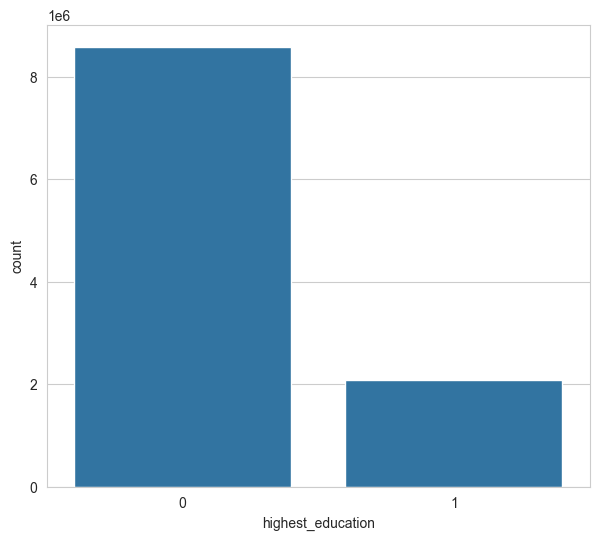

In [81]:
plt.figure(figsize=(7, 6))
sns.countplot(x='highest_education', data=student_info)
plt.show()

final_result                         Distinction       Fail       Pass  \
highest_education highest_education                                      
0                 0                    17.316366  13.279299  60.050712   
1                 1                    27.893797   8.299806  56.287437   

final_result                         Withdrawn  
highest_education highest_education             
0                 0                   9.353623  
1                 1                   7.518961  


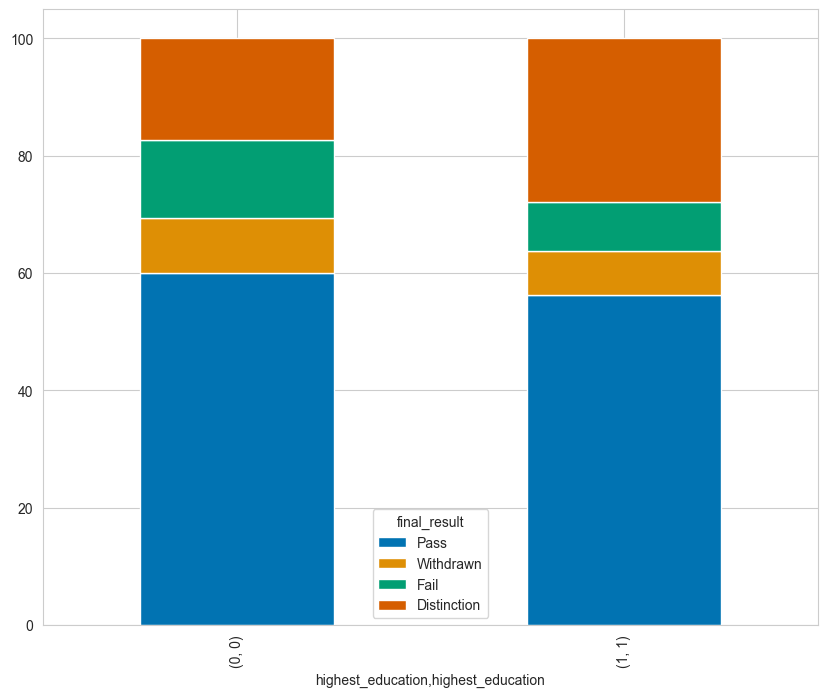

In [82]:
## Kita cari tahu rasio final result untuk pendidikan tingkat atas vs bawah
## Dapat dilihat bahwa pendidikan tingkat bawah mempunyai rasio pengunduran diri dan kegagalan jauh lebih tinggi
stacked_plot(student_info, 'highest_education', 'final_result', 'id_student', plot_size=(10, 8))

final_result                               Distinction       Fail       Pass  \
region               region                                                    
East Anglian Region  East Anglian Region     19.922799  12.863479  58.995552   
East Midlands Region East Midlands Region    18.805105  11.930435  59.310250   
Ireland              Ireland                 14.833910  12.957183  65.425079   
London Region        London Region           18.872789  14.084339  57.706678   
North Region         North Region            24.757927   9.154522  57.161950   
North Western Region North Western Region    16.207791  14.970109  58.749662   
Scotland             Scotland                20.029423  11.865626  59.370593   
South East Region    South East Region       21.210984   9.756240  60.879811   
South Region         South Region            20.015659   9.722879  61.737801   
South West Region    South West Region       20.900030  10.846378  59.975807   
Wales                Wales              

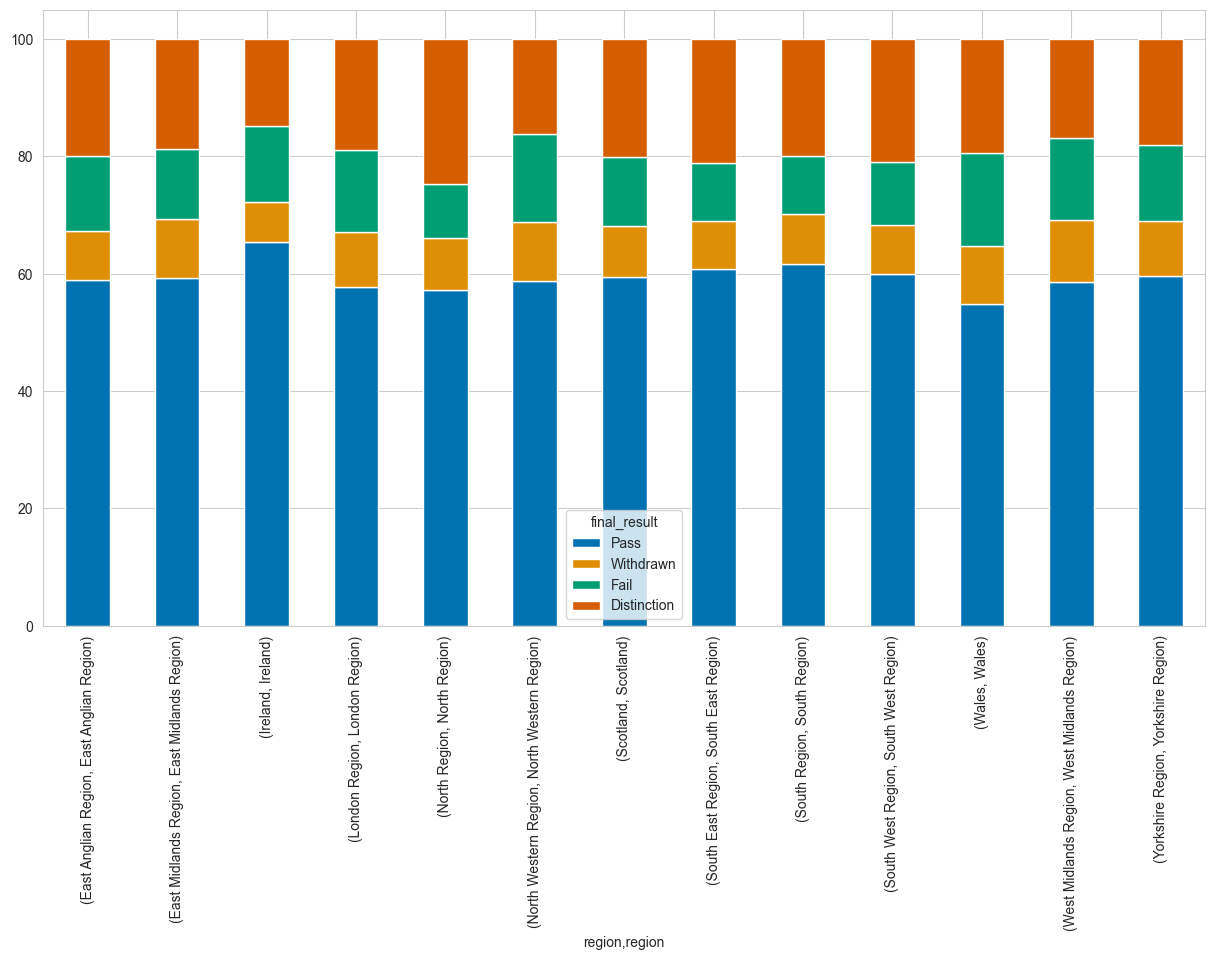

In [83]:
## Lalu coba kita analisa rasio pada fitur hasil akhir yang diukur berdasarkan region
## Dari sini dapat dilihat rasio kegagalan dan pengunduran diri nyaris setara untuk seluruh region

stacked_plot(student_info, 'region', 'final_result', 'id_student', plot_size=(15, 8))

final_result       Distinction       Fail       Pass  Withdrawn
imd_band imd_band                                              
0-10%    0-10%       12.878613  18.412286  56.243467  12.465634
10-20    10-20       13.105791  16.886718  59.474674  10.532816
20-30%   20-30%      20.022976  11.071596  59.048253   9.857175
30-40%   30-40%      18.719891  13.094015  59.615154   8.570940
40-50%   40-50%      18.660866  11.825344  59.999579   9.514211
50-60%   50-60%      19.818290  13.269201  58.533927   8.378582
60-70%   60-70%      20.020742  10.326617  60.834934   8.817707
70-80%   70-80%      21.365382  11.370586  59.184484   8.079548
80-90%   80-90%      21.402403   9.718319  61.515261   7.364016
90-100%  90-100%     26.280111   8.885122  58.408545   6.426222


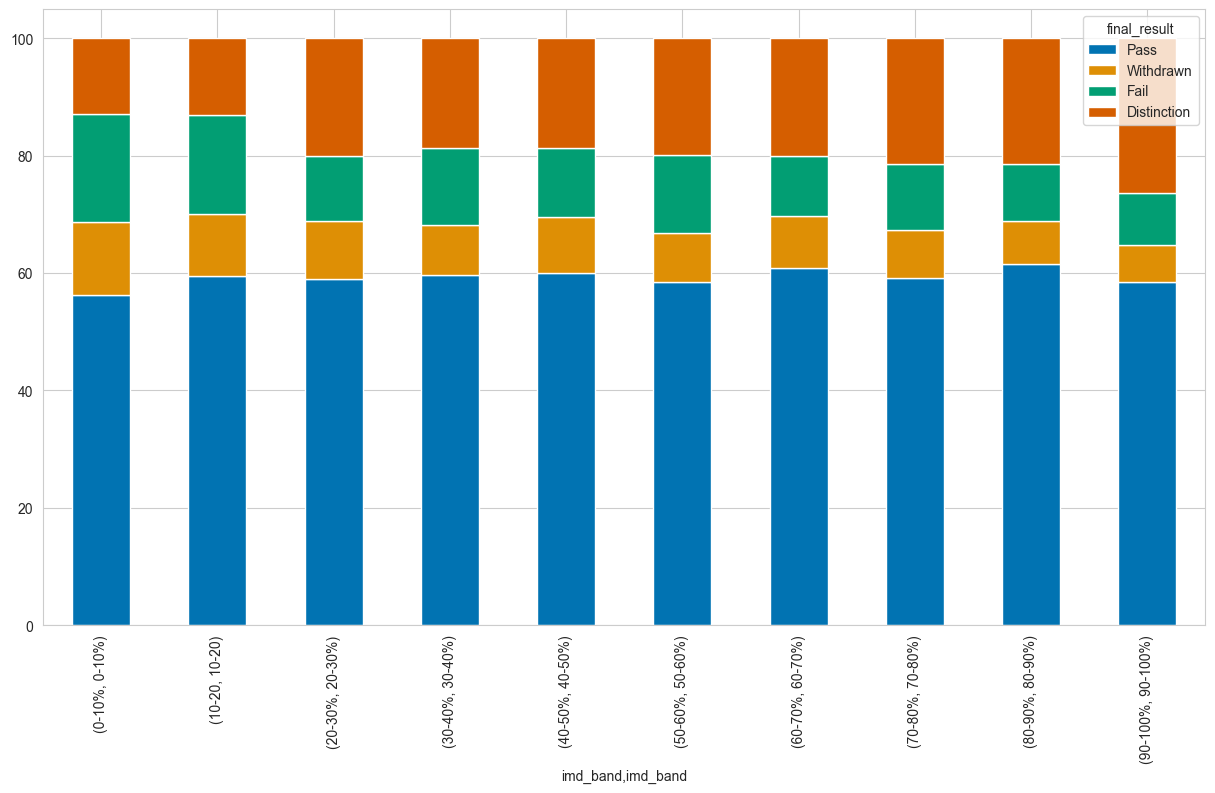

In [84]:
# Lalu kita analisa juga rasio hasil akhir berdasarkan IMD
# Dan dapat terlihat rasio kegagalan dan pengunduran diri nyaris sama kecuali untuk IMD 0-20% yang persentasenya agak melonjak
stacked_plot(student_info, 'imd_band', 'final_result', 'id_student', plot_size=(15, 8))

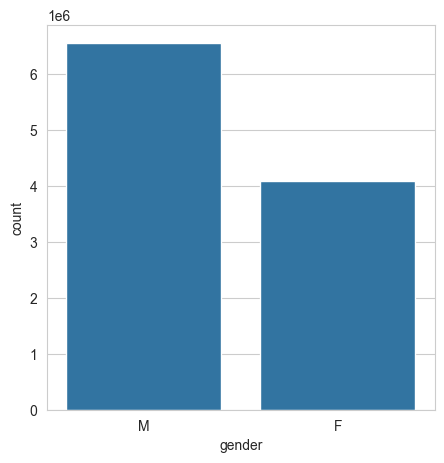

In [85]:
# Perbandingan gender
plt.figure(figsize=(5, 5))
sns.countplot(x='gender', data=student_info)
plt.show()

final_result   Distinction       Fail       Pass  Withdrawn
gender gender                                              
F      F         18.750218  12.059886  59.947131   9.242765
M      M         19.763935  12.467074  58.925991   8.843000


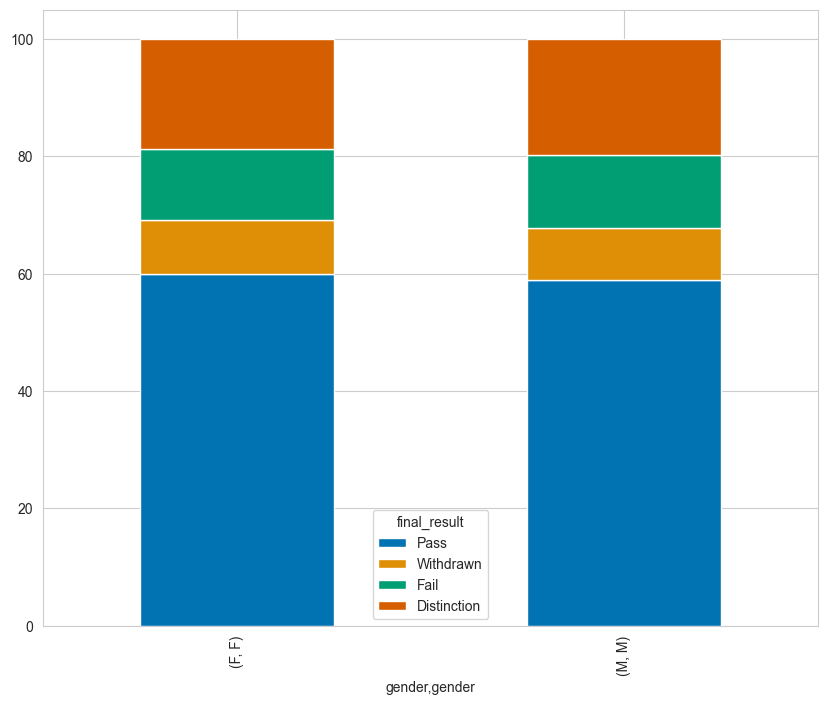

In [86]:
## Cari tahu rasio hasil akhir berdasarkan gender
## Dan terlihat bahwa rasionya ternyata tidak beda jauh antara lelaki dan perempuan untuk masing masing hasil akhir

stacked_plot(student_info, 'gender', 'final_result', 'id_student', plot_size=(10, 8))

final_result           Distinction       Fail       Pass  Withdrawn
disability disability                                              
N          N             19.658078  12.118194  59.804484   8.419244
Y          Y             16.314342  14.383852  54.080575  15.221231


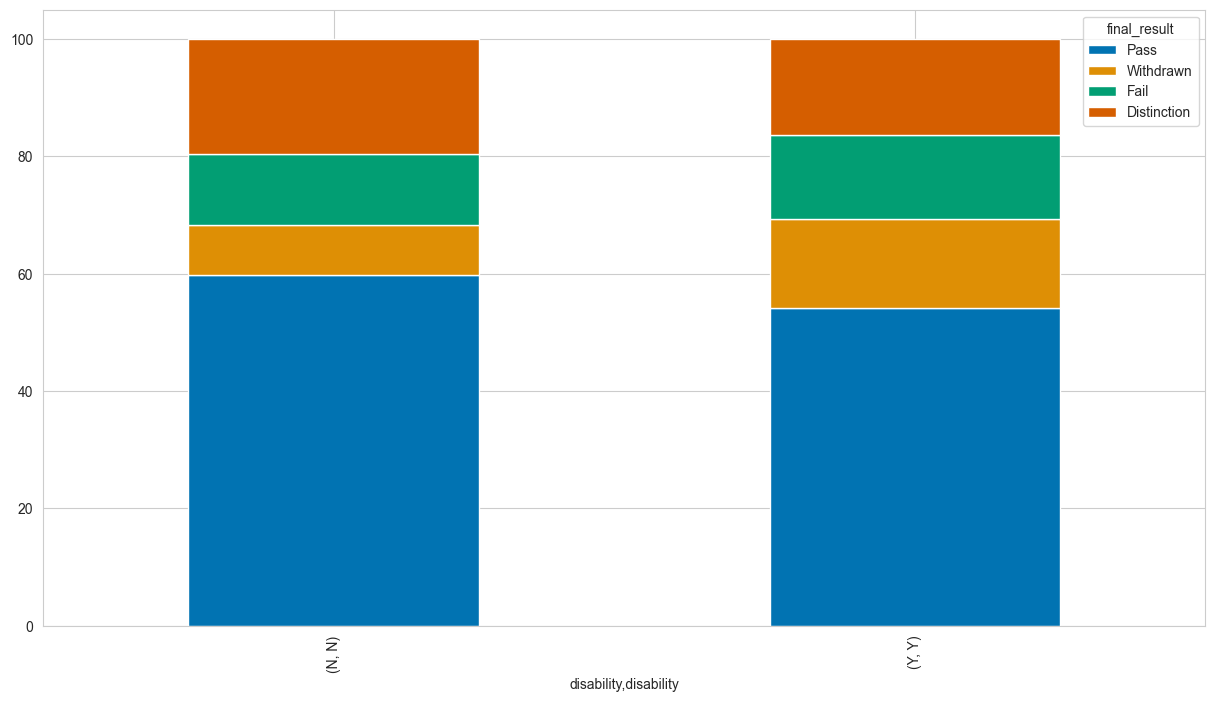

In [87]:
# Sekarang kita lihat rasio final result berdasarkan disabilitas
# Rasio pengunduran diri banyak di siswa yang mempunyai disabilitas


stacked_plot(student_info, 'disability', 'final_result', 'id_student', plot_size=(15, 8))

###### Integrasi Student Info dengan Student Registration

In [88]:
student_registration_merge_courses = student_registration_merge_courses.drop('date_unregistration', axis = 1)

In [89]:
student_info = student_info.merge(student_registration_merge_courses,
                                 on = ['code_module', 'code_presentation', 'id_student'],
                                 how = 'left')

final_result                   Distinction       Fail       Pass  Withdrawn
Starting_Month Starting_Month                                              
February       February          18.108867  14.628176  57.171860  10.091097
October        October           20.149178  10.891097  60.633307   8.326419


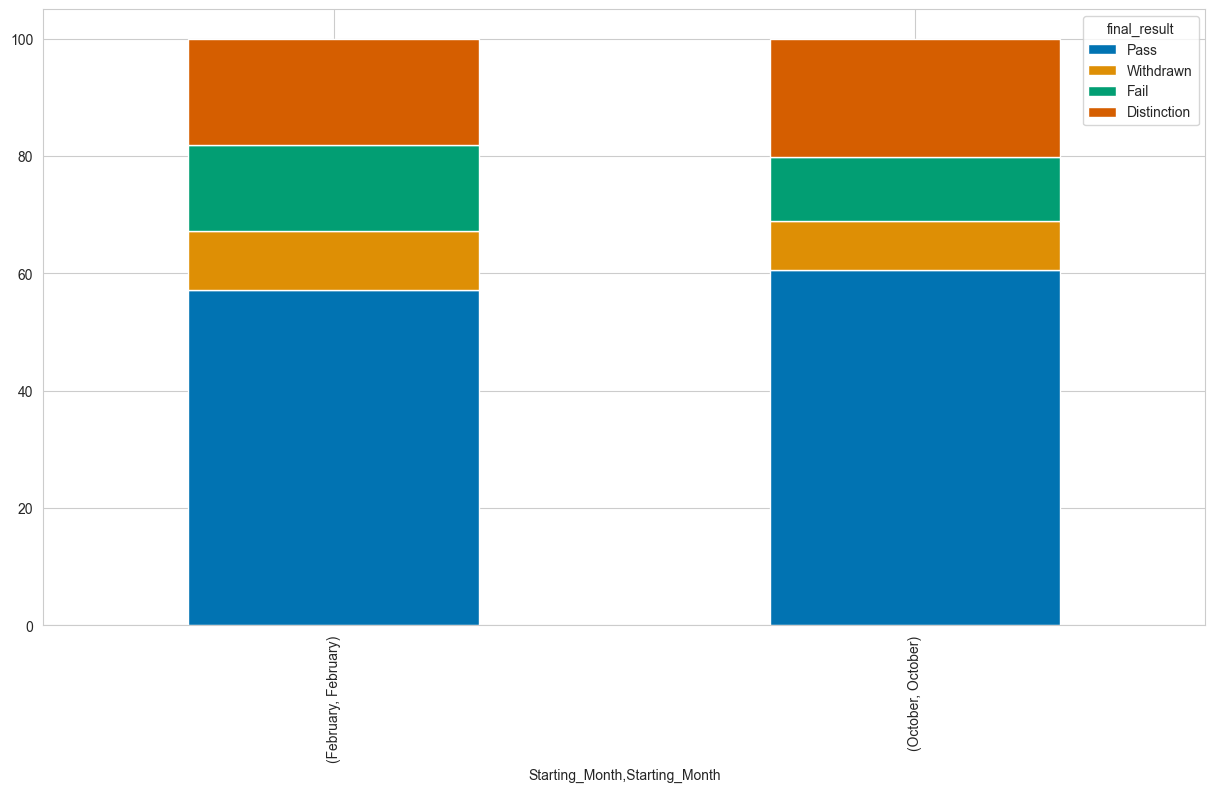

In [90]:
## Setiap course selalu dimulai pada Februari dan October mengacu pada dataset maka kita coba analisa failure rate berdasarkan bulannya
## Dapat dilihat bahwa tidak ada perbedaan signifikan kecuali Fail dan Withdrawn lebih banyak pada siswa yang memulai course
## pada bulan Februari

stacked_plot(student_info, 'Starting_Month', 'final_result', 'id_student', plot_size=(15, 8))

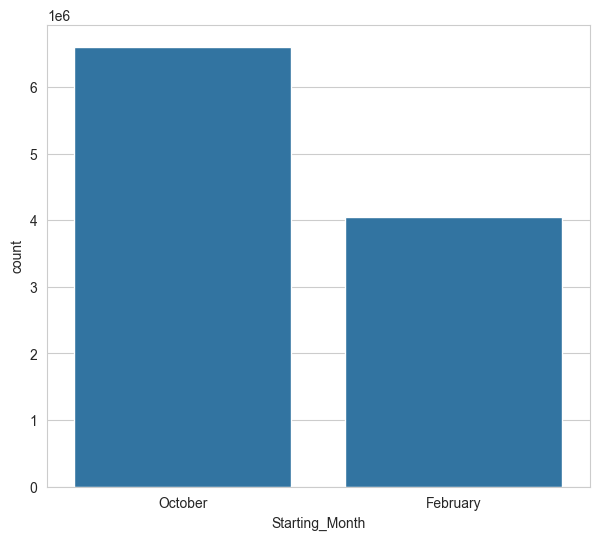

In [91]:
# Jumlah orang yang mendaftar pada bulan Februari lebih sedikit dibandingkan dengan Oktober. 
# Namun, tingkat kegagalan dan tingkat penarikan diri tetap lebih tinggi untuk bulan Februari.
# Mungkin mahasiswa tidak suka konten atau kursus yang ditawarkan pada bulan Februari.

plt.figure(figsize=(7, 6))
sns.countplot(x='Starting_Month', data=student_info)
plt.show()

final_result                               Distinction       Fail       Pass  \
num_of_prev_attempts num_of_prev_attempts                                      
0                    0                       20.280652  11.396905  59.669725   
1                    1                       11.777832  19.480844  56.596650   
2                    2                        9.156117  25.749018  51.869438   
3                    3                        1.973395  33.615627  54.799664   
4                    4                        0.000000  16.525305  79.625315   
5                    5                        0.000000  40.507614  49.035533   
6                    6                       21.710526  18.092105   0.000000   

final_result                               Withdrawn  
num_of_prev_attempts num_of_prev_attempts             
0                    0                      8.652719  
1                    1                     12.144675  
2                    2                     13.225427  
3   

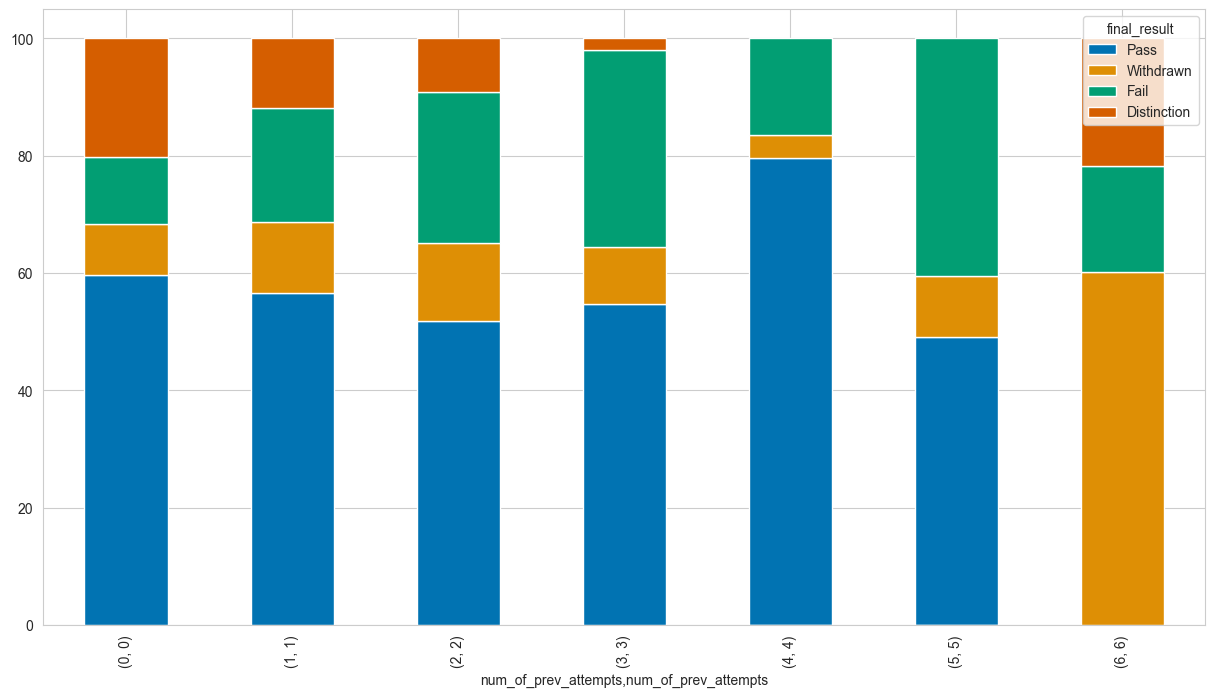

In [92]:
# Dari plot, kita dengan jelas dapat melihat bahwa tingkat kegagalan dan tingkat penarikan diri paling rendah terjadi pada siswa 
# yang tidak pernah mengikuti kursus sebelumnya atau yang memiliki jumlah percobaan sebelumnya == 0.


stacked_plot(student_info, 'num_of_prev_attempts', 'final_result', 'id_student', plot_size=(15, 8))


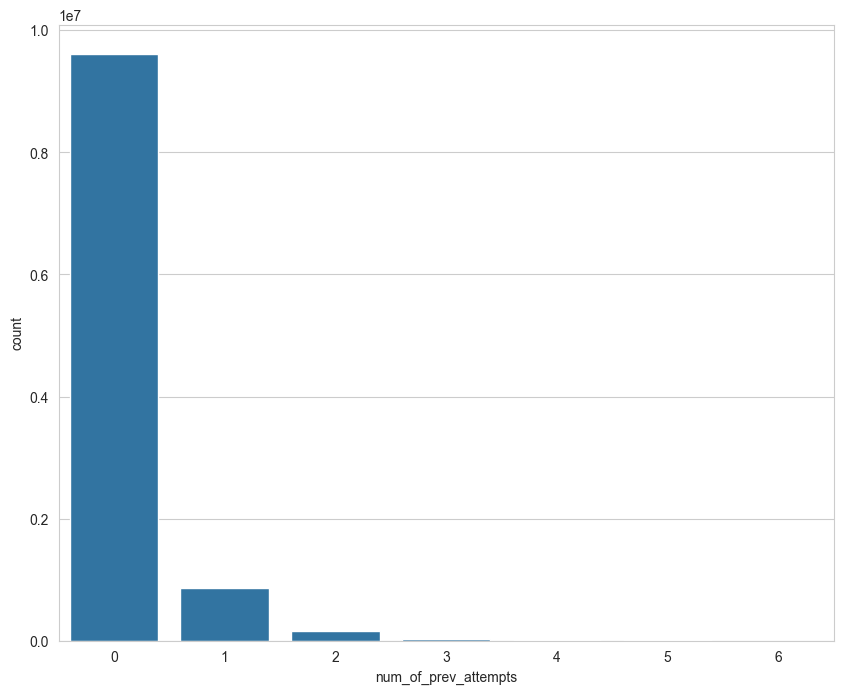

In [93]:
# Sebagian besar data adalah untuk jumlah percobaan nol, yang menyebabkan ketidakseimbangan dalam fitur (num_of_prev_att) ini. 
# Kita perlu mengumpulkan lebih banyak data untuk menciptakan keseimbangan dalam fitur tersebut. 
# Sebagai gantinya, kita akan memanipulasi fitur ini untuk menciptakan dua kategori saja, yaitu 0 dan 1, 
# di mana 0 menunjukkan tidak ada percobaan sebelumnya dan 1 menunjukkan adanya percobaan sebelumnya.

plt.figure(figsize=(10, 8))
sns.countplot(x='num_of_prev_attempts', data=student_info)
plt.show()

In [94]:
student_info['num_of_prev_attempts'] = [0 if attempts == 0 else 1 for attempts in student_info['num_of_prev_attempts']]

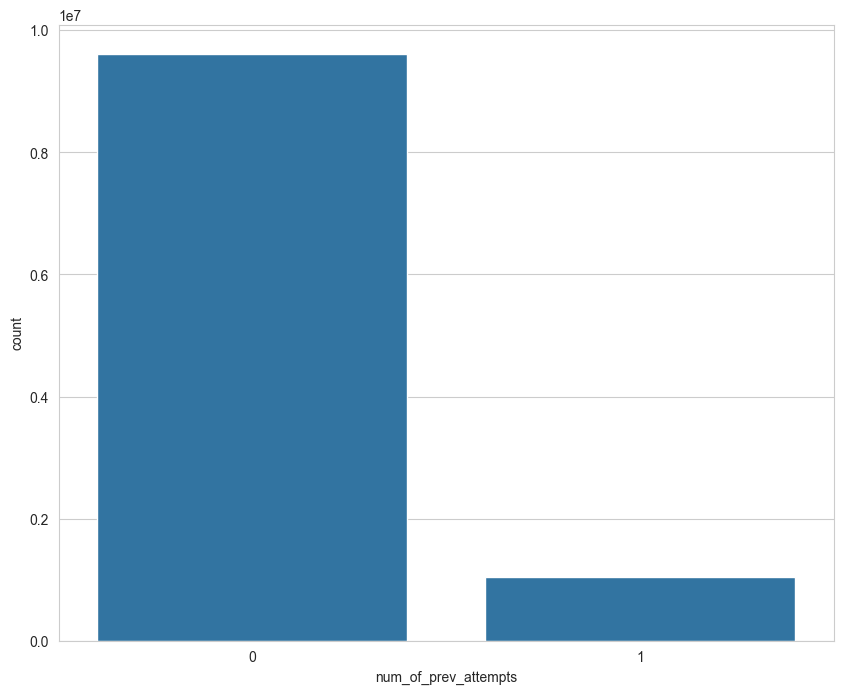

In [95]:
## Tetap tidak seimbang tapi lebih baik dibandingkan sebelumnya

plt.figure(figsize=(10, 8))
sns.countplot(x='num_of_prev_attempts', data=student_info)
plt.show()

final_result                               Distinction       Fail       Pass  \
num_of_prev_attempts num_of_prev_attempts                                      
0                    0                       20.280652  11.396905  59.669725   
1                    1                       11.028638  20.722340  56.085401   

final_result                               Withdrawn  
num_of_prev_attempts num_of_prev_attempts             
0                    0                      8.652719  
1                    1                     12.163621  


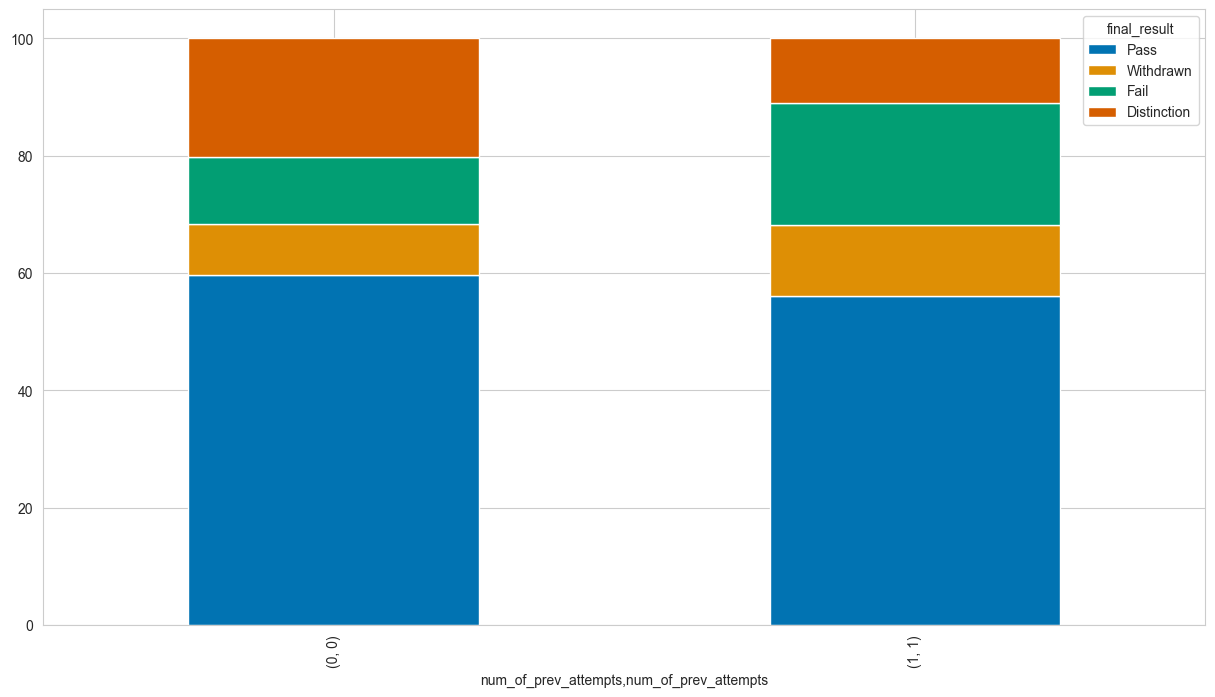

In [96]:
# Dari plot ini kita bisa melihat bahwa orang orang dengan percobaan sebelumnya memiliki tingkat gagal dan undur diri lebih banyak

stacked_plot(student_info, 'num_of_prev_attempts', 'final_result', 'id_student', plot_size=(15, 8))

final_result             Distinction       Fail       Pass  Withdrawn
code_module code_module                                              
AAA         AAA            12.294789   5.089763  74.299408   8.316039
BBB         BBB            18.295874  12.761951  61.797519   7.144656
CCC         CCC            27.677405  12.222270  46.414401  13.685923
DDD         DDD            13.149483  14.829122  59.953217  12.068179
EEE         EEE            25.216132   8.476711  61.480198   4.826959
FFF         FFF            19.296797  12.297266  60.079289   8.326648
GGG         GGG            25.366537  12.853532  59.179638   2.600293


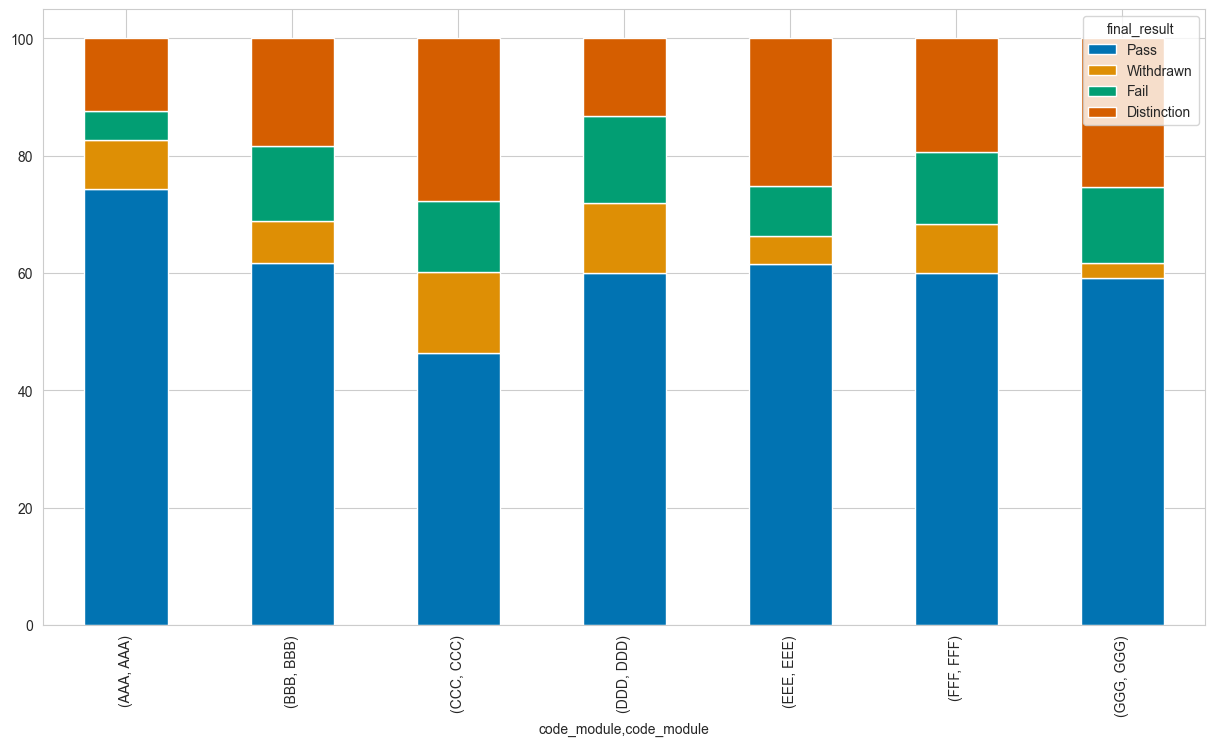

In [97]:
## Lalu kita analisa rasio hasil akhir per modulnya
## Dapat dilihat modul BBB,CCC,DDD,FFF, dan GGG mempunyai tingkat kegagalan yang banyak
## sedangkan tingkat undur diri lebih banyak pada dua modul yaitu CCC dan DDD

stacked_plot(student_info, 'code_module', 'final_result', 'id_student', plot_size=(15, 8))

Kita buat fitur modul berdasarkan domainnya lagi lalu kita analisa failure rate dari domain tersebut

In [98]:
student_info['Code_Category'] = ['Social_Science' if student_info['code_module'].iloc[i] in ['AAA', 'BBB', 'GGG']
                                 else 'STEM' for i in range(len(student_info))]

final_result                   Distinction       Fail       Pass  Withdrawn
Code_Category  Code_Category                                               
STEM           STEM              19.595799  12.503415  58.231026   9.669759
Social_Science Social_Science    18.571838  11.612081  63.256670   6.559411


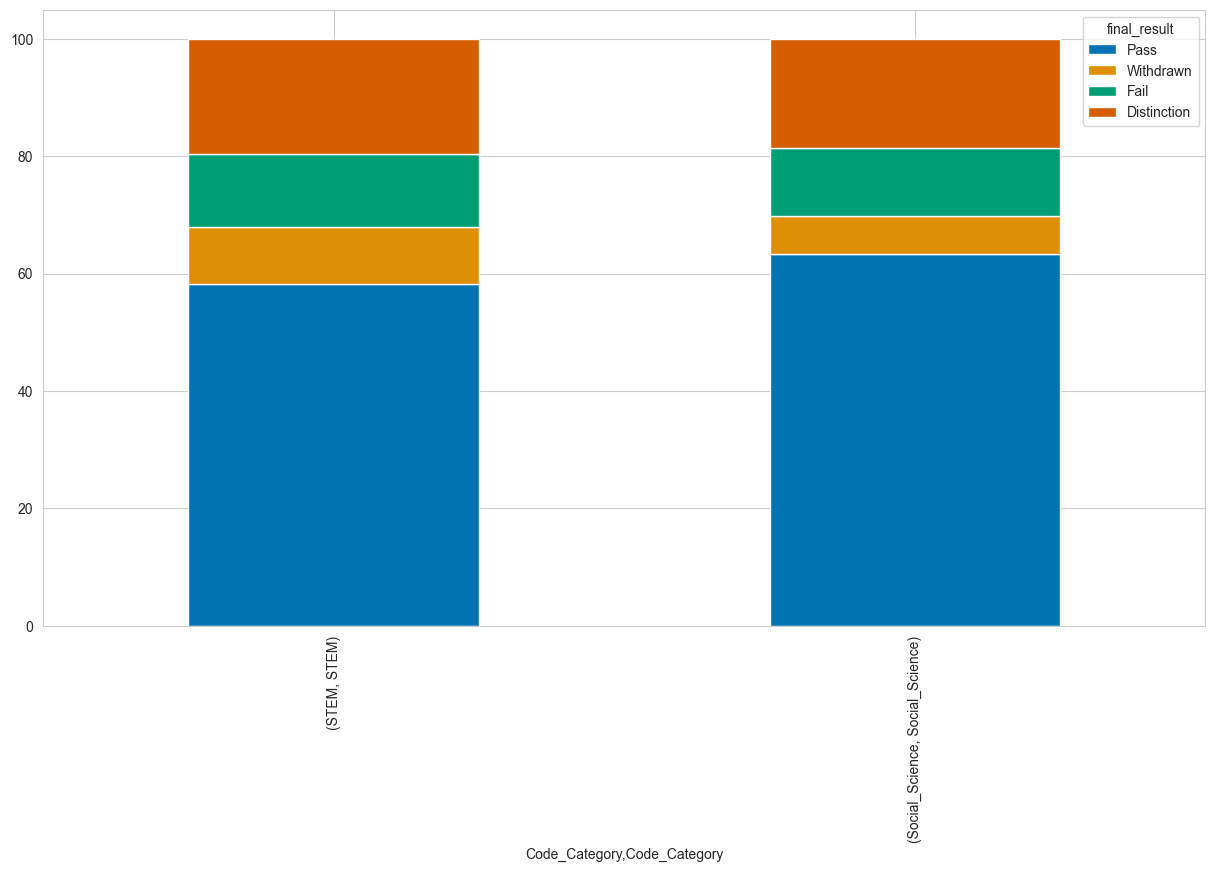

In [99]:
## Dari plot di bawah bisa dilihat bahwa rasio kegagalan dan pengunduran diri lebih banyak terjadi di domain STEM
## walaupun kelulusan dengan predikat (distinction) juga lebih banyak di domain STEM
## Hal ini mungkin juga disebabkan karena siswa pada domain STEM lebih banyak dibandingkan Social Sciences

stacked_plot(student_info, 'Code_Category', 'final_result', 'id_student', plot_size=(15, 8))

# DATA PREPARATION
#### Feature Selection
#### Data Encoding
#### Splitting Data

In [100]:
# Disini akan kita drop tabel code_presentation,id_student, dan year karena tidak berpengaruh pada hasil akhir

student_info = student_info.drop(['code_presentation', 'id_student', 'Year'], axis = 1)

In [101]:
student_info['date_registration'] = student_info['date_registration'].astype(float)

In [102]:
student_info['date_registration'].describe()

count    1.065864e+07
mean     6.931983e+01
std      4.764116e+01
min      0.000000e+00
25%      2.900000e+01
50%      5.700000e+01
75%      9.900000e+01
max      3.220000e+02
Name: date_registration, dtype: float64

In [103]:
student_info.head()

,code_module,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,id_site,date,sum_click,activity_type,Click_Timing,After_Clicks,Before_Clicks,date_registration,module_presentation_length,Starting_Month,Code_Category
0,AAA,M,East Anglian Region,1,90-100%,55<=,0,240,N,Pass,546669.0,-5.0,16.0,oucontent,Before,0.0,16.0,159.0,268,October,Social_Science
1,AAA,M,East Anglian Region,1,90-100%,55<=,0,240,N,Pass,546662.0,-5.0,44.0,oucontent,Before,0.0,44.0,159.0,268,October,Social_Science
2,AAA,M,East Anglian Region,1,90-100%,55<=,0,240,N,Pass,546652.0,-5.0,1.0,forumng,Before,0.0,1.0,159.0,268,October,Social_Science
3,AAA,M,East Anglian Region,1,90-100%,55<=,0,240,N,Pass,546668.0,-5.0,2.0,oucontent,Before,0.0,2.0,159.0,268,October,Social_Science
4,AAA,M,East Anglian Region,1,90-100%,55<=,0,240,N,Pass,546652.0,-5.0,1.0,forumng,Before,0.0,1.0,159.0,268,October,Social_Science


Pada cell di bawah kita akan melakukan drop pada fitur fitur yang tidak akan digunakan dalam menentukan hasil akhir atau output model yang akan dibuat

In [104]:
student_info = student_info.drop(['id_site','date','activity_type'],axis=1)

In [105]:
student_info = student_info.drop(['Click_Timing'],axis=1)

Lalu kita cek apakah fitur yang tidak diperlukan sudah benar benar hilang

In [106]:
student_info.head()

,code_module,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,sum_click,After_Clicks,Before_Clicks,date_registration,module_presentation_length,Starting_Month,Code_Category
0,AAA,M,East Anglian Region,1,90-100%,55<=,0,240,N,Pass,16.0,0.0,16.0,159.0,268,October,Social_Science
1,AAA,M,East Anglian Region,1,90-100%,55<=,0,240,N,Pass,44.0,0.0,44.0,159.0,268,October,Social_Science
2,AAA,M,East Anglian Region,1,90-100%,55<=,0,240,N,Pass,1.0,0.0,1.0,159.0,268,October,Social_Science
3,AAA,M,East Anglian Region,1,90-100%,55<=,0,240,N,Pass,2.0,0.0,2.0,159.0,268,October,Social_Science
4,AAA,M,East Anglian Region,1,90-100%,55<=,0,240,N,Pass,1.0,0.0,1.0,159.0,268,October,Social_Science


In [107]:
# Ada dua tipe data di tabel yaitu Nominal dan Ordinal (Nominal dan Ordinal)
# Maka kita akan melakukan pengkategorian berdasarkan nominal dan ordinalnya
# 1. NOMINAL :- Here there is no order in the categories
# 2. ORDINAL :- When there is order in the category

nominal_columns = ['gender', 'region', 'disability', 'Starting_Month', 'code_module', 'Code_Category']
ordinal_columns = ['highest_education', 'imd_band', 'age_band']

In [108]:
data = labelEncoder(student_info, ordinal_columns)
data = categorical_encoding(student_info, nominal_columns)

['M' 'F']
['East Anglian Region' 'Scotland' 'North Western Region'
 'South East Region' 'West Midlands Region' 'Wales' 'North Region'
 'South Region' 'Ireland' 'South West Region' 'East Midlands Region'
 'Yorkshire Region' 'London Region']
['N' 'Y']
['October' 'February']
['AAA' 'BBB' 'CCC' 'DDD' 'EEE' 'FFF' 'GGG']
['Social_Science' 'STEM']


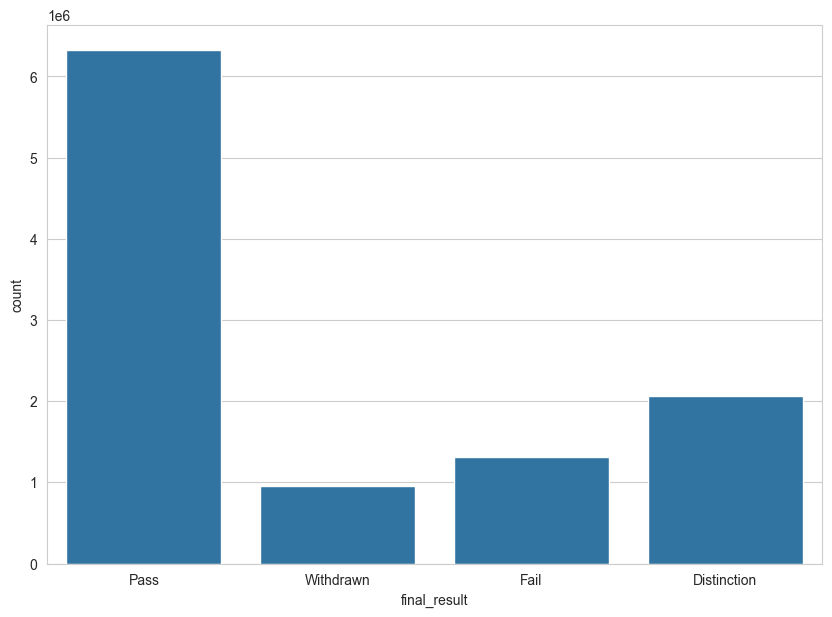

In [109]:
plt.figure(figsize=(10, 7))
sns.countplot(x='final_result', data=data)
plt.show()

#### Pada kasus pertama, bisa diasumsikan bahwa kelas "Withdrawn" setara dengan "Fail" dan kami membangun model untuk memprediksi apakah seorang mahasiswa akan lulus atau gagal.
#### Pada kasus kedua, kita membuat label untuk kategori "dropout" (keluar) vs. "non-dropout" (tidak keluar) dan membangun model menggunakan label tersebut.


Di bawah akan ada 3 cell di mana masing masing akan mengelompokkan fitur melalui kategorinya ada yang categorical, numerik, dan boolean

In [110]:
cat_columns = [ col for col in list(data.columns) if data[col].dtype =='object' and col!= 'label']

cat_columns

['final_result']

In [111]:
bool_columns = [ col for col in list(data.columns) if data[col].dtype =='bool' and col!= 'label']

bool_columns

['gender_F',
 'gender_M',
 'region_East Anglian Region',
 'region_East Midlands Region',
 'region_Ireland',
 'region_London Region',
 'region_North Region',
 'region_North Western Region',
 'region_Scotland',
 'region_South East Region',
 'region_South Region',
 'region_South West Region',
 'region_Wales',
 'region_West Midlands Region',
 'region_Yorkshire Region',
 'disability_N',
 'disability_Y',
 'Starting_Month_February',
 'Starting_Month_October',
 'code_module_AAA',
 'code_module_BBB',
 'code_module_CCC',
 'code_module_DDD',
 'code_module_EEE',
 'code_module_FFF',
 'code_module_GGG',
 'Code_Category_STEM',
 'Code_Category_Social_Science']

In [112]:
num_columns = [ col for col in list(data.columns) if data[col].dtype in ['int64','float64']]
num_columns

['highest_education',
 'num_of_prev_attempts',
 'studied_credits',
 'sum_click',
 'After_Clicks',
 'Before_Clicks',
 'date_registration',
 'module_presentation_length']

Di bawah ini akan kita encode setiap kolom yang bernilai boolean dikarenakan model random forest hanya menerima tipe data numerik


In [113]:
label_encoders = {}
columns = bool_columns
for col in columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le
data

,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,final_result,sum_click,After_Clicks,Before_Clicks,date_registration,module_presentation_length,gender_F,gender_M,region_East Anglian Region,region_East Midlands Region,region_Ireland,region_London Region,region_North Region,region_North Western Region,region_Scotland,region_South East Region,region_South Region,region_South West Region,region_Wales,region_West Midlands Region,region_Yorkshire Region,disability_N,disability_Y,Starting_Month_February,Starting_Month_October,code_module_AAA,code_module_BBB,code_module_CCC,code_module_DDD,code_module_EEE,code_module_FFF,code_module_GGG,Code_Category_STEM,Code_Category_Social_Science
0,1,9,2,0,240,Pass,16.0,0.0,16.0,159.0,268,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1
1,1,9,2,0,240,Pass,44.0,0.0,44.0,159.0,268,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1
2,1,9,2,0,240,Pass,1.0,0.0,1.0,159.0,268,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1
3,1,9,2,0,240,Pass,2.0,0.0,2.0,159.0,268,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1
4,1,9,2,0,240,Pass,1.0,0.0,1.0,159.0,268,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10658640,1,5,1,0,30,Distinction,13.0,13.0,0.0,28.0,269,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,1
10658641,1,5,1,0,30,Distinction,2.0,2.0,0.0,28.0,269,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,1
10658642,1,5,1,0,30,Distinction,1.0,1.0,0.0,28.0,269,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,1
10658643,1,5,1,0,30,Distinction,31.0,31.0,0.0,28.0,269,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,1


In [114]:
# Untuk membangun model kelas biner yang disederhanakan, saya memberi label "Distinction" dan "Pass" sebagai 0, 
# dan "Withdrawn" dan "Failure" sebagai 1.

data['Result']  = [0 if result in ['Pass', 'Distinction'] else 1 for result in data['final_result']]

In [115]:
# Dalam langkah ini, saya membuat kolom "dropout" di mana kami mempertimbangkan "withdrawn" sebagai "keluar" (dropout) 
# dan semua yang lain sebagai "tidak keluar" (non-dropout).
# '0' : Tidak Keluar, '1' : Keluar (Withdrawn)

data['dropout'] = [0 if result in ['Pass', 'Distinction', 'Fail'] else 1 for result in data['final_result']]

In [116]:
## Lalu kita bagi fitur dan targetnya

feature = data.drop(['final_result', 'Result'], axis = 1)
target  = data['Result']

In [117]:
# Di sini, kami akan membagi data kami menjadi data pelatihan dan pengujian. Karena kami memiliki data yang terbatas, 
# Kita akan menyimpan 80% data untuk pelatihan dan hanya 20% untuk pengujian. 
# Kita ingin memiliki lebih banyak data jika memungkinkan, di mana Kita dapat membuat tiga set data terpisah 
# untuk pelatihan, validasi, dan pengujian. 
# Karena tujuan kami di sini adalah untuk menemukan fitur-fitur yang memengaruhi keputusan apakah seorang siswa akan gagal atau tidak, 
# kita akan menggunakan sebagian besar data untuk pelatihan saja.


X_train, X_test, Y_train, Y_test = train_test_split(feature, target, 
                                                    test_size = 0.2, 
                                                    random_state = 123, 
                                                    stratify=data.final_result)

In [113]:
# Pada langkah ini, kita akan membuat set fitur dan target untuk kasus keluar (dropout) vs. tidak keluar (non-dropout).

feature_dropout = data.drop(['final_result', 'dropout', 'Result'], axis = 1)
target_dropout  = data['dropout']

In [114]:
target_dropout.value_counts()

dropout
0    9699720
1     958925
Name: count, dtype: int64

In [115]:
## Splitting Data into training and test sets

X_train_dropout, X_test_dropout, Y_train_dropout, Y_test_dropout = train_test_split(feature_dropout, target_dropout, 
                                                                                    test_size = 0.2, 
                                                                                    random_state = 123, 
                                                                                    stratify=target_dropout)

In [116]:
data.head()

,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,final_result,sum_click,After_Clicks,Before_Clicks,date_registration,module_presentation_length,gender_F,gender_M,region_East Anglian Region,region_East Midlands Region,region_Ireland,region_London Region,region_North Region,region_North Western Region,region_Scotland,region_South East Region,region_South Region,region_South West Region,region_Wales,region_West Midlands Region,region_Yorkshire Region,disability_N,disability_Y,Starting_Month_February,Starting_Month_October,code_module_AAA,code_module_BBB,code_module_CCC,code_module_DDD,code_module_EEE,code_module_FFF,code_module_GGG,Code_Category_STEM,Code_Category_Social_Science,Result,dropout
0,1,9,2,0,240,Pass,16.0,0.0,16.0,159.0,268,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0
1,1,9,2,0,240,Pass,44.0,0.0,44.0,159.0,268,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0
2,1,9,2,0,240,Pass,1.0,0.0,1.0,159.0,268,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0
3,1,9,2,0,240,Pass,2.0,0.0,2.0,159.0,268,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0
4,1,9,2,0,240,Pass,1.0,0.0,1.0,159.0,268,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0


In [117]:
target.value_counts()

Result
0    8387584
1    2271061
Name: count, dtype: int64

XGBOOST TRIAL

In [118]:
# Menggunakan parameter yang setara dengan RandomForestClassifier
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    random_state=123,
    max_depth=30,
    min_child_weight=50,  # Parameter setara dengan min_samples_split pada RandomForestClassifier
    n_jobs=4
)

# Melatih model
xgb_model.fit(X_train, Y_train)



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=30, max_leaves=None,
              min_child_weight=50, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=4,
              num_parallel_tree=None, random_state=123, ...)

In [119]:
# Membuat prediksi
y_pred = xgb_model.predict(X_test)

# Evaluasi performa model
accuracy = accuracy_score(Y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9980621364160266


In [120]:
# Membuat classification report
classification_rep = classification_report(Y_test, y_pred)

# Menampilkan classification report
print("Classification Report:\n", classification_rep)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1677517
           1       1.00      0.99      1.00    454212

    accuracy                           1.00   2131729
   macro avg       1.00      1.00      1.00   2131729
weighted avg       1.00      1.00      1.00   2131729



In [136]:
## Predicting on Test Data using fitted model

predictions_boost = xgb_model.predict(X_test)

In [137]:
print(confusion_matrix(Y_test, predictions_boost))

[[1676935     582]
 [   3549  450663]]


# BUILDING AND EVALUATING MODEL

#### Building a model to predict whether student will pass or fail

In [121]:
## Initializing the Random Forest Model

random_forest_model = RandomForestClassifier(n_estimators=100, 
                                             random_state=123, 
                                             max_depth=25,
                                             min_samples_split = 100,
                                             n_jobs=4)

In [122]:
## Fitting the model using Training Data

random_forest_model.fit(X_train, Y_train)

RandomForestClassifier(max_depth=25, min_samples_split=100, n_jobs=4,
                       random_state=123)

In [123]:
## Predicting on Test Data using fitted model

predictions_random = random_forest_model.predict(X_test)

In [124]:
print(confusion_matrix(Y_test, predictions_random))

[[1677381     136]
 [  50751  403461]]


In [125]:
print("Accuracy of the model is ", accuracy_score(Y_test, predictions_random))

Accuracy of the model is  0.9761287668366851


In [126]:
print(classification_report(Y_test, predictions_random, digits=2))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99   1677517
           1       1.00      0.89      0.94    454212

    accuracy                           0.98   2131729
   macro avg       0.99      0.94      0.96   2131729
weighted avg       0.98      0.98      0.98   2131729



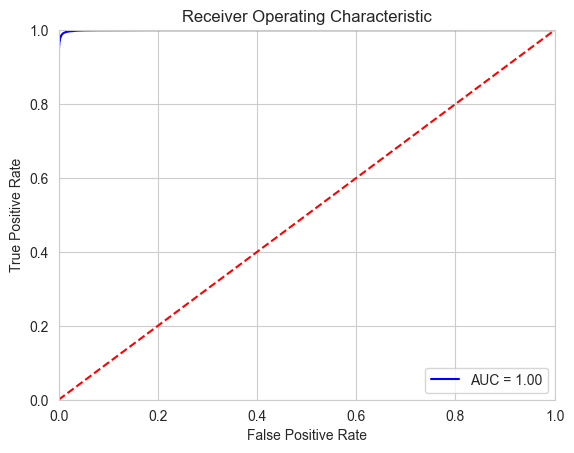

In [127]:
predictions_rf = random_forest_model.predict_proba(X_test)
preds = predictions_rf[:,1]
y_test = np.array(Y_test)
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### USING GRID SEARCH FOR HYPERPARAMETER OPTIMIZATION

In [128]:
# n_estimators      = [100, 300, 500, 800, 1200]
# max_depth         = [5, 8, 15, 25, 30]
# min_samples_split = [50, 100, 150, 250, 300]
# min_samples_leaf  = [1, 2, 5, 10] 

# hyperF  = {'n_estimators' : n_estimators, 
#            'max_depth' : max_depth,  
#            'min_samples_split' : min_samples_split, 
#            'min_samples_leaf' : min_samples_leaf}

# gridF   = GridSearchCV(random_forest_model, hyperF, cv = 3, verbose = 1)
# bestF   = gridF.fit(X_train, Y_train)

In [129]:
# bestF.best_params_

# {'max_depth': 30,
#  'min_samples_leaf': 1,
#  'min_samples_split': 50,
#  'n_estimators': 100}

In [130]:
random_forest_model_best_fit = RandomForestClassifier(n_estimators=100, 
                                                      random_state=123, 
                                                      max_depth=30,
                                                      min_samples_split = 50,
                                                      n_jobs=4)

In [131]:
random_forest_model_best_fit.fit(X_train, Y_train)

RandomForestClassifier(max_depth=30, min_samples_split=50, n_jobs=4,
                       random_state=123)

In [132]:
predict_best_fit = random_forest_model_best_fit.predict(X_test)

In [135]:
print(confusion_matrix(Y_test, predict_best_fit))

[[1677119     398]
 [  10620  443592]]


In [133]:
print(classification_report(predict_best_fit, Y_test))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00   1687739
           1       0.98      1.00      0.99    443990

    accuracy                           0.99   2131729
   macro avg       0.99      1.00      0.99   2131729
weighted avg       0.99      0.99      0.99   2131729



In [134]:
## Dapat terlihat pada region mempunyai sangat sedikit bahkan hampir tidak ada impact pada output model, jadi bisa dihilangkan saja fitur ini

importance = pd.concat([pd.DataFrame(X_train.columns),
                          pd.DataFrame(np.transpose(random_forest_model.feature_importances_))], axis = 1)
importance.columns = ['Features', 'Coeff']
importance = importance.sort_values('Coeff', ascending=False)
importance

,Features,Coeff
38,dropout,0.427029
8,date_registration,0.175350
1,imd_band,0.084998
4,studied_credits,0.054914
9,module_presentation_length,0.028627
2,age_band,0.020889
3,num_of_prev_attempts,0.012791
10,gender_F,0.011293
11,gender_M,0.010976
0,highest_education,0.010356


#### Building a model to predict whether student will dropout or not

In [135]:
random_forest_model_drop = RandomForestClassifier(n_estimators=100, 
                                                  random_state=123, 
                                                  max_depth=25,
                                                  min_samples_split = 100,
                                                  class_weight = {0: 1, 1: 2},
                                                  n_jobs=4)

In [136]:
random_forest_model_drop.fit(X_train_dropout, Y_train_dropout)

RandomForestClassifier(class_weight={0: 1, 1: 2}, max_depth=25,
                       min_samples_split=100, n_jobs=4, random_state=123)

In [137]:
predict_dropout = random_forest_model_drop.predict(X_test_dropout)

In [138]:
print(classification_report(predict_dropout, Y_test_dropout))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99   1970667
           1       0.83      0.99      0.91    161062

    accuracy                           0.98   2131729
   macro avg       0.92      0.99      0.95   2131729
weighted avg       0.99      0.98      0.99   2131729



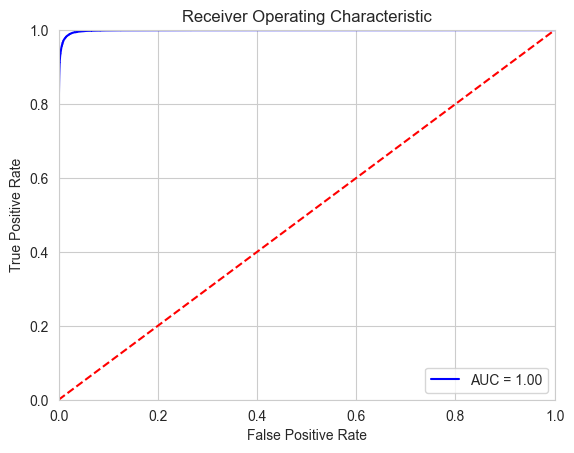

In [139]:
predictions_rf = random_forest_model_drop.predict_proba(X_test_dropout)
preds = predictions_rf[:,1]
y_test = np.array(Y_test_dropout)
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [140]:
importance = pd.concat([pd.DataFrame(X_train_dropout.columns),
                          pd.DataFrame(np.transpose(random_forest_model_drop.feature_importances_))], axis = 1)
importance.columns = ['Features', 'Coeff']
importance = importance.sort_values('Coeff', ascending=False)
importance

,Features,Coeff
8,date_registration,0.306185
1,imd_band,0.149028
4,studied_credits,0.089974
9,module_presentation_length,0.047137
2,age_band,0.045763
0,highest_education,0.024956
3,num_of_prev_attempts,0.021727
10,gender_F,0.018328
11,gender_M,0.018049
18,region_Scotland,0.016865


Try Using MLP

In [118]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import confusion_matrix, classification_report
from keras.callbacks import EarlyStopping

# Model Sequential
deep_learning_model = Sequential()

# Layer dari Model MLP
deep_learning_model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
deep_learning_model.add(Dense(64, activation='relu'))
deep_learning_model.add(Dropout(0.3)) 
deep_learning_model.add(Dense(1, activation='sigmoid'))

# Inisialisasi EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Run Model dengan EarlyStopping dan validation_split
deep_learning_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
deep_learning_model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping])



Epoch 1/10
213173/213173 [==============================] - 522s 2ms/step - loss: 0.3538 - accuracy: 0.8735 - val_loss: 0.3405 - val_accuracy: 0.8778
Epoch 2/10
213173/213173 [==============================] - 515s 2ms/step - loss: 0.3398 - accuracy: 0.8782 - val_loss: 0.3368 - val_accuracy: 0.8784
Epoch 3/10
213173/213173 [==============================] - 514s 2ms/step - loss: 0.3357 - accuracy: 0.8796 - val_loss: 0.3300 - val_accuracy: 0.8809
Epoch 4/10
213173/213173 [==============================] - 516s 2ms/step - loss: 0.3335 - accuracy: 0.8808 - val_loss: 0.3271 - val_accuracy: 0.8827
Epoch 5/10
213173/213173 [==============================] - 515s 2ms/step - loss: 0.3324 - accuracy: 0.8815 - val_loss: 0.3248 - val_accuracy: 0.8844
Epoch 6/10
213173/213173 [==============================] - 516s 2ms/step - loss: 0.3326 - accuracy: 0.8818 - val_loss: 0.3260 - val_accuracy: 0.8828
Epoch 7/10
213173/213173 [==============================] - 519s 2ms/step - loss: 0.3322 - accuracy:

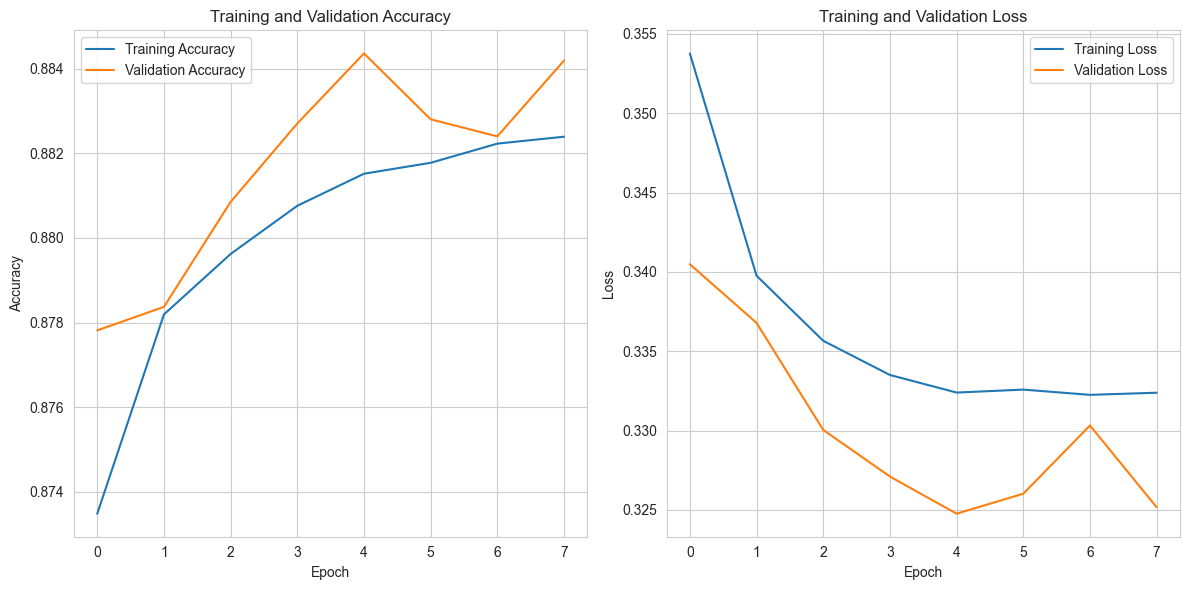

In [119]:
# Ambil nilai akurasi dan loss dari model
train_acc = deep_learning_model.history.history['accuracy']
train_loss = deep_learning_model.history.history['loss']
val_acc = deep_learning_model.history.history['val_accuracy']
val_loss = deep_learning_model.history.history['val_loss']

# Plot Training & Validation Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Training & Validation Loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [119]:
#Evaluate model
accuracy = deep_learning_model.evaluate(X_test, Y_test)
print(f'Accuracy: {accuracy[1]}')

# CR dan CM
y_pred = deep_learning_model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)
cm = confusion_matrix(Y_test, y_pred_binary)
print("Confusion Matrix:")
print(cm)
report = classification_report(Y_test, y_pred_binary)
print("Classification Report:")
print(report)


66617/66617 [==============================] - 104s 2ms/step - loss: 0.3213 - accuracy: 0.8841
Accuracy: 0.8840649724006653
66617/66617 [==============================] - 90s 1ms/step
Confusion Matrix:
[[1675920    1597]
 [ 245545  208667]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93   1677517
           1       0.99      0.46      0.63    454212

    accuracy                           0.88   2131729
   macro avg       0.93      0.73      0.78   2131729
weighted avg       0.90      0.88      0.87   2131729

